#### Notebook options

In [121]:
%load_ext autoreload
# Set extension to reload modules every time before executing code
%autoreload 2  #0 to turn of reloading

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [122]:
### Print not only the last line in a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [123]:
### Don't autoclose brackets
from notebook.services.config import ConfigManager
c = ConfigManager()
c.update('notebook', {"CodeCell": {"cm_config": {"autoCloseBrackets": False}}})

{'Cell': {'cm_config': {'lineNumbers': True}},
 'CodeCell': {'cm_config': {'autoCloseBrackets': False}},
 'load_extensions': {'jupyter-js-widgets/extension': True}}

#### Imports

In [124]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
from scipy.optimize import curve_fit
import matplotlib as mpl
import os
from JetEtaBins import JetEtaBins, PtBins

In [434]:
from plotters.pltStyle import pltStyle
import mplhep as hep
pltStyle(style='hep')
# plt.rcParams['figure.subplot.left'] = 0.162
plt.rcParams['figure.dpi'] = 150

In [126]:
from helpers import read_data
# def read_data(name, samp):
#     df_csv = pd.read_csv('out_txt/EtaBinsvsPtBins'+name+'_'+samp+tag_full+'.csv').set_index('etaBins')
#     data = df_csv.to_numpy().transpose()
#     return data

# def read_data2(name, samp, tag_full):
#     df_csv = pd.read_csv('out_txt/EtaBinsvsPtBins'+name+'_'+samp+tag_full+'.csv').set_index('etaBins')
#     data = df_csv.to_numpy().transpose()
#     return data

### Fitting the inverse median responses

In [127]:
# from scipy.optimize import fsolve
from scipy.optimize import brentq
# scipy.optimize.brentq

def find_stationary_pnt_poly4(xmin, xmax, *p):
    '''Finds the last x within the limits [xmin, xmax], where the derivative of the 4-th order polynomial with
    coefficients p, changes sign. If there is no such point in outputs xmax.  '''
    c0, c1, c2, c3, c4 = p
    xmin = np.log10(xmin)
    xmax = np.log10(xmax)
    xs = np.linspace(xmin, xmax,1000)
    
    deriv = lambda xs: c1+2*c2*xs+c3*3*xs**2+4*c4*xs**3
    signx = np.sign(deriv(xs))
    changes_sign = signx[1:]*signx[:-1]
    last_change_idx = np.where(changes_sign==-1)[0]
    if len(last_change_idx)==0:
        last_change_idx = 0
        root = xmax
    else:
        last_change_idx = last_change_idx[-1]
        root = brentq(deriv, xs[last_change_idx], xs[last_change_idx+1] )
    print(last_change_idx)
    
    return 10**root

In [128]:
# last_root_poly4(1,1000,*[1.00763381e+00, -2.78489790e-02,  7.05158220e-02, -4.41251949e-02, 8.04056510e-03])

In [129]:
def poly4(x, *p):
    c0, c1, c2, c3, c4 = p
    xs = np.log10(x)
    res = c0+c1*xs+c2*xs**2+c3*xs**3+c4*xs**4
    return res

def poly4lims(x, xmin, xmax, *p):
    xcp = x.copy()
    lo_pos = xcp<xmin
    hi_pos = xcp>xmax
    xcp[lo_pos] = xmin
    xcp[hi_pos] = xmax
    return poly4(xcp, *p)

def poly3(x, *p):
    c0, c1, c2, c3 = p
    xs = np.log10(x)
    res = c0+c1*xs+c2*xs**2+c3*xs**3
    return res

def poly3lims(x, xmin, xmax, *p):
    xcp = x.copy()
    lo_pos = xcp<xmin
    hi_pos = xcp>xmax
    xcp[lo_pos] = xmin
    xcp[hi_pos] = xmax
    return poly3(xcp, *p)
    

In [130]:
def response_fnc_raw(x, p0, p1, p2, p3, p4, p5):
    response_fnc(x, *[p0, p1, p2, p3, p4, p5])

In [131]:
def response_fnc(x, *p):
    p0, p1, p2, p3, p4, p5 = p
    logx = np.log10(x)
    return p0+(p1/((logx**2)+p2)) + (p3*np.exp(-p4*((logx-p5)*(logx-p5))))

def two_gaus_fnc(x, *p):
    p0, p1, p2, p3, p4, p5, p6, p7, p8 = p
    return (  p0
            + (p1/((np.log10(x)**2)+p2))
            + (p3*np.exp(-p4*((np.log10(x)-p5)*(np.log10(x)-p5))))
            + (p6*np.exp(-p7*((np.log10(x)-p8)*(np.log10(x)-p8))))
           )
#     return A*np.exp(-(x-mu)**2/(2.*sigma**2))

In [132]:
#### initial values borrowed from Winter14 data
#### https://github.com/cms-jet/JECDatabase/blob/master/textFiles/Winter14_V8_MC/Winter14_V8_MC_L5Flavor_AK5Calo.txt/
#### used for fit `response_fnc`
init_vals_2014 = {
    'b':
    [[0.540002, 13.8495, 17.8549, -0.215711, 0.576285, 1.42258],
    [0.73119, 7.52866, 17.3681, -0.078402, 1.21665, 1.69878],
    [0.999952, 0.0322738, -1.05606, -19.6994, 0.720321, -1.58314],
    [0.135913, 7.92441, 3.85698, -0.804604, 1.11911, 0.732041]],
    'c' :
    [[ 0.940259, 0.705481, 0.23917, -0.826926, 0.311473, -0.514041],
    [0.982083, 0.238007, 4.35924, -0.0314618, 5.91028, 1.67749],
    [0.733505, 7.26794, 12.2028, -0.756302, 0.0895257, -1.96324],
    [0.932305, 1.15954, 17.1731, -0.471313, 2.58424, 0.254917]],
    'g' :
    [[0.877892, 3.10194, 1.16568, -677.876, 0.0325026, -12.9485],
    [0.983775, 0.247943, 1.55373, -0.0254802, 3.35748, 1.71263],
    [-0.972548, 38.8683, 2.47151, -44.0233, 0.0901665, -3.15495],
    [1.0655, -0.0680325, -0.509038, -8.59434e+06, 42.6162, 0.357177]],
    'd':
    [[1.28488, -46.3648, 151.749, -0.0108461, 15.4256, 1.63377],
    [ 1.50931, -118.71, 224.19, -0.0196468, 4.62655, 1.51581],
    [0.692016, 8.26488, 11.1655, -0.802769, 0.116182, -1.16094],
    [1.01244, -0.0926519, -0.12138, -3.69494e+07, 7.15634, -0.625288]],  
    'u':
    [[1.28488, -46.3648, 151.749, -0.0108461, 15.4256, 1.63377],
    [ 1.50931, -118.71, 224.19, -0.0196468, 4.62655, 1.51581],
    [0.692016, 8.26488, 11.1655, -0.802769, 0.116182, -1.16094],
    [1.01244, -0.0926519, -0.12138, -3.69494e+07, 7.15634, -0.625288]],  
    's':
    [[1.28488, -46.3648, 151.749, -0.0108461, 15.4256, 1.63377],
    [ 1.50931, -118.71, 224.19, -0.0196468, 4.62655, 1.51581],
    [0.692016, 8.26488, 11.1655, -0.802769, 0.116182, -1.16094],
    [1.01244, -0.0926519, -0.12138, -3.69494e+07, 7.15634, -0.625288]],
    'all':
    [[0.540002, 13.8495, 17.8549, -0.215711, 0.576285, 1.42258],
    [0.73119, 7.52866, 17.3681, -0.078402, 1.21665, 1.69878],
    [0.999952, 0.0322738, -1.05606, -19.6994, 0.720321, -1.58314],
    [0.135913, 7.92441, 3.85698, -0.804604, 1.11911, 0.732041]],  
    'ud':
    [[1.28488, -46.3648, 151.749, -0.0108461, 15.4256, 1.63377],
    [ 1.50931, -118.71, 224.19, -0.0196468, 4.62655, 1.51581],
    [0.692016, 8.26488, 11.1655, -0.802769, 0.116182, -1.16094],
    [1.01244, -0.0926519, -0.12138, -3.69494e+07, 7.15634, -0.625288]],  
    'q':
    [[1.28488, -46.3648, 151.749, -0.0108461, 15.4256, 1.63377],
    [ 1.50931, -118.71, 224.19, -0.0196468, 4.62655, 1.51581],
    [0.692016, 8.26488, 11.1655, -0.802769, 0.116182, -1.16094],
    [1.01244, -0.0926519, -0.12138, -3.69494e+07, 7.15634, -0.625288]],
    
}

## Initial values for the two gaussian fit
init_two_gaus = [3,0,1,2,0,1,2,3,4]

Better starting fit values I found

In [133]:
init_vals_2014['b'][0] = [ 9.81014871e-01, -6.46744813e-03, -1.05658840e+00,  5.35445486e+03, 2.99200015e+01,  1.21399356e+02]
init_vals_2014['b'][3] = [ 9.81014871e-01, -6.46744813e-03, -1.05658840e+00,  5.35445486e+03, 2.99200015e+01,  1.21399356e+02]

### Fitting the mean responses

In [134]:
my_mapping = {"all": "aT",
              "b": "bT",
              "c": "cT",
              "s": "sT",
              "g": "gT",
              "u": "uT",
              "d": "dT",
              "ud": "udT",
              "q": "qT"}

In [135]:
figdir = "fig/median_correction_fits"

if not os.path.exists(figdir):
    os.mkdir(figdir)

In [136]:
from scipy.stats import chi2

In [520]:
def fit_corrections(etabin, inlist, flav, data_tag,
                    figdir2=figdir+'correction_fit',
                    jeteta_bins=JetEtaBins(), pt_bins=PtBins(),
                    init_vals_Winter14=np.array([1,1,1,1,1,1]),
                    plot_initial_val=False,
                    use_recopt=True, maxlimit_static_pnt=True, max_ptval=None ):
    mean, meanstd, reco_pt = inlist
#     meanstd = mean**2*read_data("MedianStd", samp)[:,etabin]
#     reco_pt = read_data("MeanRecoPt", samp)[:,etabin]
    if maxlimit_static_pnt:
        if max_ptval==None:
            max_ptval=5000
        else:
            raise ValueError("Remove `max_ptval` if using `maxlimit_static_pnt`. `max_ptval` given as {max_ptval} but `maxlimit_static_pnt` is set to {maxlimit_static_pnt}.")
    elif max_ptval==None:
        max_ptval=500
            
            

    ### pt limits for the fit
    ptmin_idx = np.searchsorted(pt_bins.centres, 30, side='left')-1 #-1: so that the first bin includes the value
    ptmax_idx = np.searchsorted(pt_bins.centres, max_ptval, side='right')
#     ptmax_idx = len(reco_pt)
    mean_range = range(ptmin_idx, ptmax_idx)


#         mean_range = mean_range_pt[:-1]

#         ptbins2fit = ptbins[mean_range_pt]
#         ptbins2fit = (ptbins2fit[:-1]+ptbins2fit[1:])/2
    means = mean[mean_range]
    ptbins2fit = reco_pt[mean_range] if use_recopt else pt_bins.centres[mean_range]
    validpt_mask = ~(np.isnan(means) | np.isinf(means) | (means==0))

    means2fit = means[validpt_mask]
    ptbins2fit = ptbins2fit[validpt_mask]
    meanstd = np.abs(meanstd[mean_range][validpt_mask])

    ### Put the minimum limit on the relative uncertainty to min_rel_uncert
#     meanstd = np.sqrt(meanvar2fit)
    meanstd_orig = meanstd.copy()
    where_limit_std = (meanstd/means2fit)<min_rel_uncert
    meanstd[where_limit_std] = min_rel_uncert*means2fit[where_limit_std]

    if sum(validpt_mask)==0:
        fit_res_new = np.concatenate([[jeteta_bins.edges[etabin], jeteta_bins.edges[etabin+1],
                               5, 
                               pt_bins.centres[ptmin_idx], pt_bins.centres[ptmax_idx-1]],
                              [1,0,0,0,0] ])
        print("No points to fit. Returning a unity function.")
        return fit_res_new
    
    fit_min_lim = min(ptbins2fit)
    fit_max_lim = max(ptbins2fit)

    xplot = np.linspace(ptbins2fit.min(), ptbins2fit.max(),1000)

#     print("init_vals_Winter14", init_vals_Winter14)
    try:
        p_resp, arr = curve_fit(response_fnc, ptbins2fit, means2fit, p0=init_vals_Winter14) #0.793149, 4.60568, 11.1553, -0.123262, 0.878497, 1.52041
        p_resp_err, arr = curve_fit(response_fnc, ptbins2fit, means2fit, p0=p_resp, sigma=meanstd)
    except(RuntimeError):
        print("Winter 14 fit failed")
        p_resp, p_resp_err = [[np.nan]*6]*2
    except(TypeError):
        print("Too little points for Winter 14 fit")
        p_resp, p_resp_err = [[np.nan]*6]*2

    try:
        p_resp2, arr = curve_fit(two_gaus_fnc, ptbins2fit, means2fit, p0=init_two_gaus) #0.793149, 4.60568, 11.1553, -0.123262, 0.878497, 1.52041
        p_resp_err2, arr = curve_fit(two_gaus_fnc, ptbins2fit, means2fit, p0=p_resp2, sigma=meanstd)
    except(RuntimeError):
        print("Extended Winter 14 fit failed")
        p_resp2, p_resp_err2 = [[np.nan]*9]*2
    except(TypeError):
        print("Too little points for Extended Winter 14 fit")
        p_resp2, p_resp_err2 = [[np.nan]*9]*2
    #      = np.nan*6


    # p_resp_err
    if len(means2fit)>6:
        p_poly4_1, arr = curve_fit(poly4, ptbins2fit, means2fit, p0=[ 1, 1, 1, 1, 1])
        p_poly4, arr = curve_fit(poly4, ptbins2fit, means2fit, p0=p_poly4_1, sigma=meanstd)
        p_poly3_1, arr = curve_fit(poly3, ptbins2fit, means2fit, p0=[ 1, 1, 1, 1])
        p_poly3, arr = curve_fit(poly3, ptbins2fit, means2fit, p0=p_poly3_1, sigma=meanstd)
    else:
        p_poly4_1, p_poly4 = [[np.mean(means2fit)]+[0]*4]*2
        p_poly3_1, p_poly3 = [[np.mean(means2fit)]+[0]*3]*2

        
#     print("p_poly4", p_poly4)
#     print("fit_min_lim", fit_min_lim)
#     print("fit_max_lim", fit_max_lim)
    if maxlimit_static_pnt:
        fit_max_lim_new = find_stationary_pnt_poly4(fit_min_lim, fit_max_lim, *p_poly4)
    else:
        fit_max_lim_new = fit_max_lim
    
    chi2_poly4 = np.sum((poly4(ptbins2fit, *p_poly4) - means2fit)**2/meanstd**2)
    Ndof_poly4 = len(ptbins2fit) - 5
    
    chi2_poly3 = np.sum((poly3(ptbins2fit, *p_poly3) - means2fit)**2/meanstd**2)
    Ndof_poly3 = len(ptbins2fit) - 4

    chi2_resp = np.sum((response_fnc(ptbins2fit, *p_resp_err) - means2fit)**2/meanstd**2)
    Ndof_resp = len(ptbins2fit) - 6
    
    fit_max_lim_idx = np.searchsorted(xplot,fit_max_lim_new)
    ## if chi2 of n=3 polynomial outside the 2 one-sided std of the chi2 distribution, use n=3 polynomial.
    
    usepoly3 = chi2.ppf(1-0.158, Ndof_poly3)>chi2_poly3
    if usepoly3:
        print("Using the polinomial n=3 fit results ")
        fit_res_new = np.concatenate([[jeteta_bins.edges[etabin], jeteta_bins.edges[etabin+1],
                                   len(p_poly4), 
                                   fit_min_lim, fit_max_lim_new],
                                   np.concatenate([p_poly3, [0]]) ])
    else:
        print("Using the polinomial n=4 fit results ")
        fit_res_new = np.concatenate([[jeteta_bins.edges[etabin], jeteta_bins.edges[etabin+1],
                                   len(p_poly4), 
                                   fit_min_lim, fit_max_lim_new],
                                   p_poly4])

    
    yvals_resp = response_fnc(xplot, *p_resp)
    yvals_resp_err = response_fnc(xplot, *p_resp_err)
    y_poly4 = poly4(xplot, *p_poly4)
    y_poly3 = poly3(xplot, *p_poly3)


    fig, ax = plt.subplots()
    plt.errorbar(ptbins2fit, means2fit, yerr=meanstd, marker='o',
                 linestyle="none", label=data_tag, #{jeteta_bins.idx2plot_str(etabin)}',
                 capsize=1.7, capthick=0.9, linewidth=1.0)
    plt.errorbar(ptbins2fit, means2fit, yerr=meanstd_orig, marker='o',
         linestyle="none", label=f'Original errorbars',
         capsize=1.5, capthick=0.7, linewidth=0.9, markersize=0) #, color='blue')

#     legend = [data1[0],data2[0]]
    
    if np.isnan(chi2_resp): 
        winter14_lab = 'MC truth func failed'
    else:
        winter14_lab= 'MC truth func '+r'$\chi^2/N_{dof} = $'+r' {0:0.3g}/{1:0.0f}'.format(chi2_resp, Ndof_resp)
    
#     ax.plot(xplot, yvals_resp, label="Winer14\n", linewidth=1.2, markersize=0);
    if usepoly3:
        polytxt3 = ', selected'
        polytxt4 = ''
    else:
        polytxt3 = ''
        polytxt4 = ', selected'

    ax.plot(xplot, y_poly4, label='Poly, n=4'+r', $\chi^2/N_{dof} = $'+r' {0:0.3g}/{1:0.0f}'.format(chi2_poly4, Ndof_poly4)+polytxt4, markersize=0);
    ax.plot(xplot, y_poly3, label='Poly, n=3'+r', $\chi^2/N_{dof} = $'+r' {0:0.3g}/{1:0.0f}'.format(chi2_poly3, Ndof_poly3)+polytxt3, markersize=0);
    if maxlimit_static_pnt:
        ax.plot(xplot[:fit_max_lim_idx], y_poly4[:fit_max_lim_idx], label=r'Poly, n=4  until the last stat point', markersize=0); #,linewidth=1.2

#     ax.plot(xplot, yvals, label=r'Chebyshev, n=4, '+r'$\chi^2/N_{dof} = $'+r' {0:0.3g}/{1:0.0f}'.format(chi2_C4, Ndof_C4),linewidth=1.2);
    ax.plot(xplot, yvals_resp_err, label=winter14_lab, markersize=0); #linewidth=2.3, 
#     legend = legend+[lines1[0],lines2[0],lines3[0]]
    if plot_initial_val:
        yvals_init = response_fnc(xplot, *init_vals_Winter14)
        ax.plot(xplot, yvals_init, label="Initial values for Winter14", markersize=0);
        
    ylim_tmp = ax.get_ylim()
    ylim_pad = (ylim_tmp[1] - ylim_tmp[0])/1.3
    ax.set_ylim(ylim_tmp[0], ylim_tmp[1]+ylim_pad)
    
    std = meanstd
    norm_pos = (std<0.1) &  (std != np.inf)

    ax.set_xlabel(r'$p_{T,reco}$ (GeV)')
    ax.set_ylabel(r'correction (1/median)');
    ax.set_xscale('log')

    ax.set_xticks([])
    ax.set_xticks([20, 50, 100, 200, 500, 1000])
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    hep.cms.label("Preliminary", loc=0, data=False, ax=ax)
#     hep.label.exp_text(text=f'{bins.idx2plot_str(binidx)}\n{flav} jets', loc=2, ax=ax)
    hep.label.exp_text(text=f'{jeteta_bins.idx2plot_str(etaidx)}\n{flav} jets', loc=2)

    ### hack put errorbars before the curves in the legend
    #get handles and labels
    handles, labels = plt.gca().get_legend_handles_labels()

    #specify order of items in legend
    order = [3,4,0,1,2]

    #add legend to plot
    odered_handles = [handles[idx] for idx in order]
    ordered_labels = [labels[idx] for idx in order]
    
    # ax.set_ylim([0.8,1.1])
    ax.legend(odered_handles,
              ordered_labels,
              loc="upper left", bbox_to_anchor=(0, 0.84)) #, prop={'size': 10}
    
    figdir2 = (figdir+'/'+data_tag.replace(legend_labels["ttbar"]["lab"], 'ttbar').replace(', ', '-')
                .replace(" ", "_").replace("+", "_").replace('(', '').replace(')', '').replace('/', '').replace('\n', '')
              )
    if not os.path.exists(figdir2):
        os.mkdir(figdir2)
        
    add_name = f'correction_fit_{flav}_'+jeteta_bins.idx2str(etaidx)
    fig_name = figdir2+'/'+add_name
        
    print("Saving plot with the name = ", fig_name+".pdf / .png")
    plt.savefig(fig_name+'.pdf');
    plt.savefig(fig_name+'.png');

    plt.show();
    plt.close();
    
    return fit_res_new

In [521]:
# [data, meanstd, recopt]
def fit_corrections_for_interact(samp, etabin, p0=1, p1=1, p2=1, p3=1, p4=1, p5=1, plot_initial_val=False):
    data = read_data("Median", samp)[:,etabin]
    data[data==0] = np.nan
    mean = (1/data) #*closure[:,etabin]
    meanstd = mean**2*read_data("MedianStd", samp)[:,etabin]
    reco_pt = read_data("MeanRecoPt", samp)[:,etabin]
    fit_corrections(samp, etabin, [data, meanstd, recopt], init_vals_Winter14=np.array([p0, p1, p2, p3, p4, p5]), plot_initial_val=plot_initial_val)

In [522]:
header_txt = ('# L5 flavor corrections for IC5 algorithm \n'+
'# [gJ] (gluons from diJet mixture) \n'+
'# [bJ] (b quark from diJet mixture) \n'+
'# [cJ] (c quark from diJet mixture) \n'+
'# [qJ] (uds quarks from diJet mixture) \n'+
'# [udJ] (ud quark from diJet mixture) \n'+
'# [uJ] (u quark from diJet mixture) \n'+
'# [dJ] (d quark from diJet mixture) \n'+
'# [gT] (gluons from ttbar events) \n'+
'# [qT] (uds quarks from ttbar events) \n'+
'# [cT] (c quark from ttbar events) \n'+
'# [bT] (b quark from ttbar events) \n'+
'# energy mapping: ptGen = (pt - p5)/p6 \n'+
'# parametrization: p2+p3*logPt+p4*logPt^2, constant if Pt<p0 or Pt>p1 \n'+
'#etamin  etamax  #ofparameters  ptmin  ptmax    p2         p3        p4     mapping: p5        p6 ')

In [533]:
eta_binning  = "CoarseCalo"  ### HCalPart, JERC, CoarseCalo, CaloTowers, onebin, Summer20Flavor;
eta_binning_str = '_'+eta_binning if eta_binning != "HCalPart" else ''

jeteta_bins = JetEtaBins(eta_binning, absolute=True)
pt_bins = PtBins("MC_truth")

# fineeta = True
# fineetastr = '_fineeta' if fineeta else ''
# fineetastr = '-etaAut18'

#### Get the eta and pt bins from one example file
# tag_full = '_L5_QCD-MG-Her'+fineetastr
# tag_full = '_L5_QCD-MG-Py'+eta_binning_str
# df = pd.read_csv('out_txt/EtaBinsvsPtBins'+"Median"+"_b"+tag_full+'.csv').set_index('etaBins')

# etabins = np.append(df.index.to_numpy(), 5.191)
# ptbins = np.append(df.columns.to_numpy(float), 10000)
# ptbins_c = (ptbins[:-1]+ptbins[1:])/2

In [534]:
from helpers import legend_labels
ttbarlab = legend_labels['ttbar']['lab']

In [538]:
pltStyle(style='hep')
# plt.rcParams['figure.subplot.left'] = 0.162
plt.rcParams['figure.dpi'] = 150

plt.rcParams['figure.subplot.top'] = 0.93
plt.rcParams['figure.subplot.right'] = 0.96
# pltStyle(style='hep')
# plt.rcParams['figure.subplot.bottom'] = 0.37
plt.rcParams['figure.subplot.left'] = 0.16
plt.rcParams['font.size'] = plt.rcParams['font.size']/1.02

Fitting subsample:  all Eta idx = 0, eta bin = [0.0; 0.783 ]
Using the polinomial n=3 fit results 


/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_all_eta0p0to0p783.pdf / .png


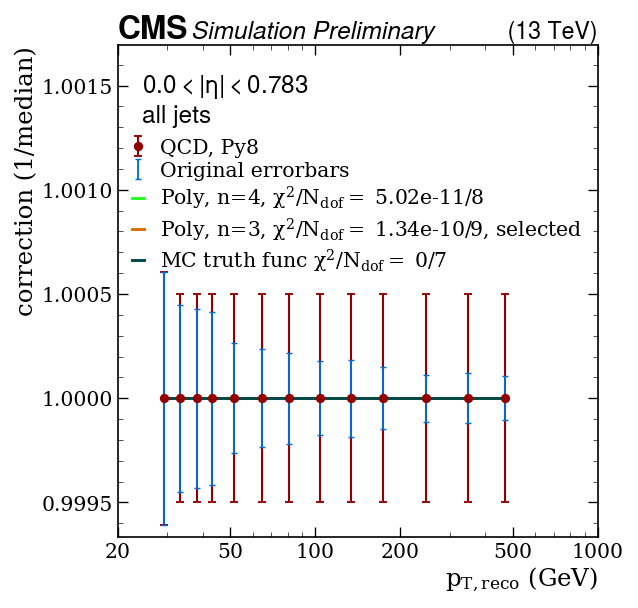

Fitting subsample:  all Eta idx = 1, eta bin = [0.783; 1.305 ]
Using the polinomial n=3 fit results 


/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/anpotreb/ipykernel_21864/164847569.py:11: RuntimeWarning: overflow encountered in exp
  + (p6*np.exp(-p7*((np.log10(x)-p8)*(np.log10(x)-p8))))


Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_all_eta0p783to1p305.pdf / .png


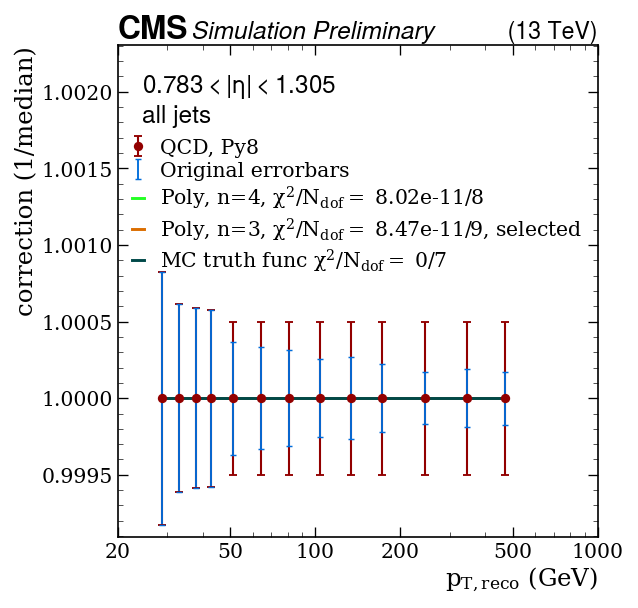

Fitting subsample:  all Eta idx = 2, eta bin = [1.305; 1.653 ]
Using the polinomial n=3 fit results 


/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/anpotreb/ipykernel_21864/164847569.py:11: RuntimeWarning: overflow encountered in exp
  + (p6*np.exp(-p7*((np.log10(x)-p8)*(np.log10(x)-p8))))


Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_all_eta1p305to1p653.pdf / .png


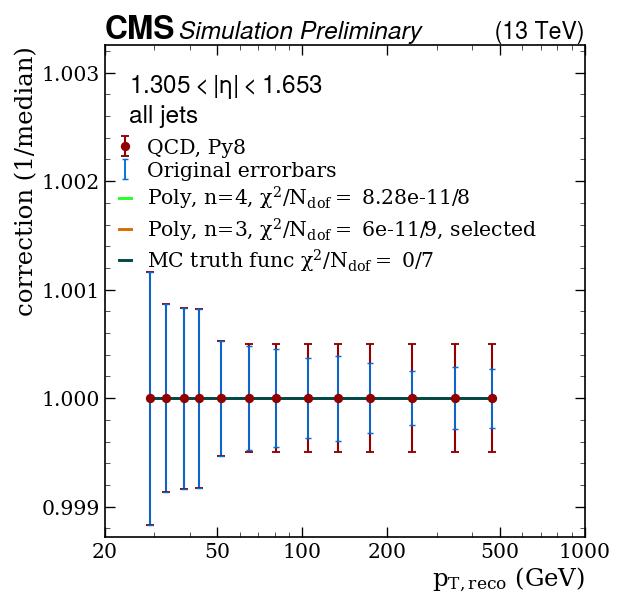

Fitting subsample:  all Eta idx = 3, eta bin = [1.653; 1.93 ]
Using the polinomial n=3 fit results 


/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/anpotreb/ipykernel_21864/164847569.py:11: RuntimeWarning: overflow encountered in exp
  + (p6*np.exp(-p7*((np.log10(x)-p8)*(np.log10(x)-p8))))


Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_all_eta1p653to1p93.pdf / .png


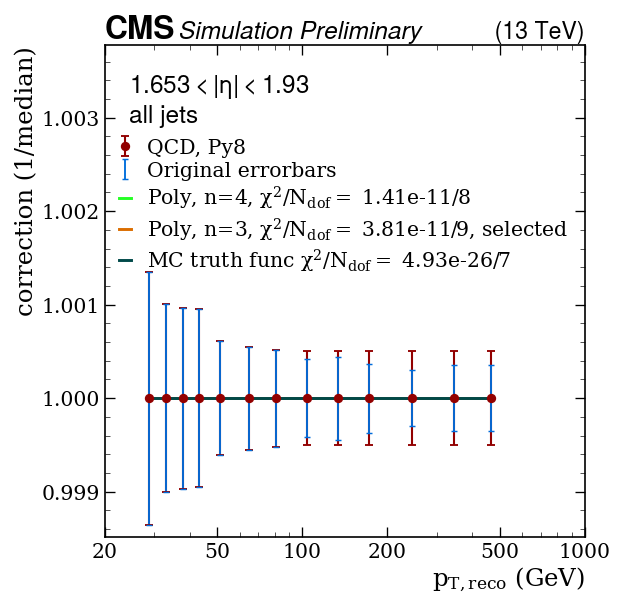

Fitting subsample:  all Eta idx = 4, eta bin = [1.93; 2.322 ]
Using the polinomial n=3 fit results 


/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_all_eta1p93to2p322.pdf / .png


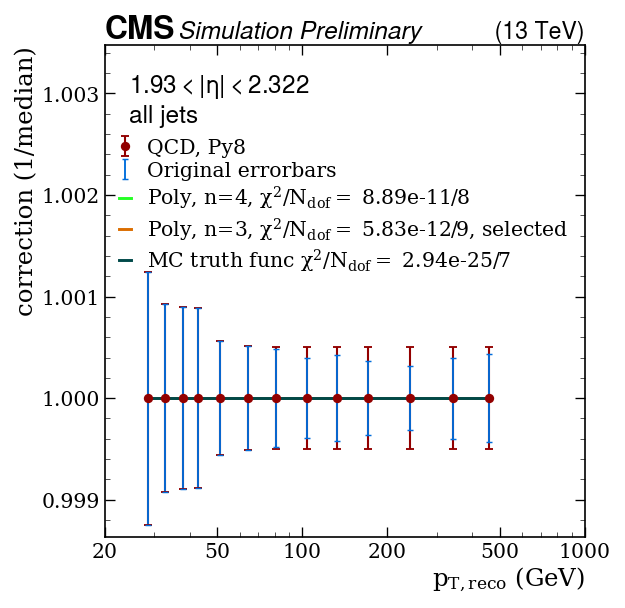

Fitting subsample:  all Eta idx = 5, eta bin = [2.322; 2.5 ]
Using the polinomial n=3 fit results 


/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/anpotreb/ipykernel_21864/164847569.py:11: RuntimeWarning: overflow encountered in exp
  + (p6*np.exp(-p7*((np.log10(x)-p8)*(np.log10(x)-p8))))


Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_all_eta2p322to2p5.pdf / .png


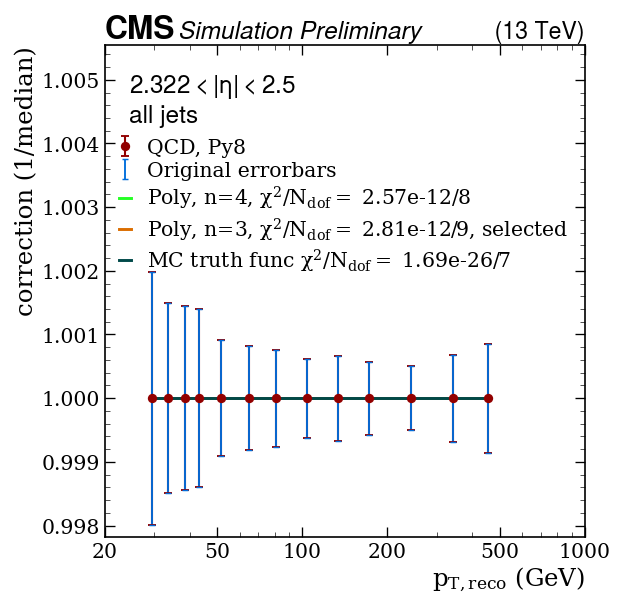

Fitting subsample:  all Eta idx = 6, eta bin = [2.5; 2.853 ]
Using the polinomial n=3 fit results 


/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_all_eta2p5to2p853.pdf / .png


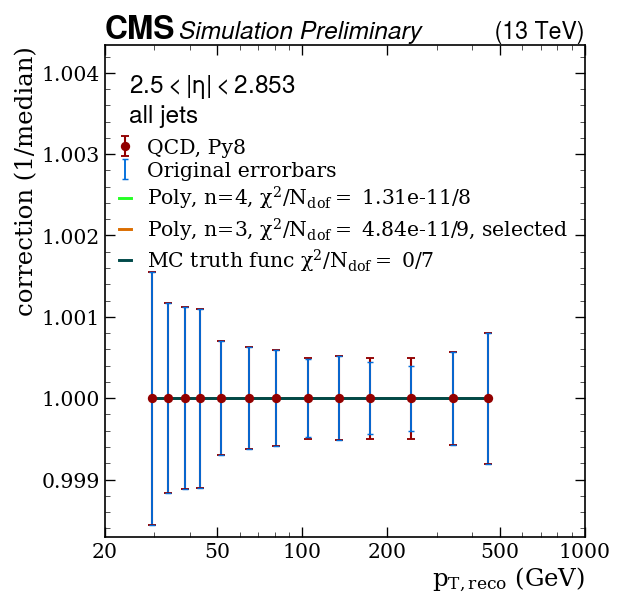

Fitting subsample:  all Eta idx = 7, eta bin = [2.853; 3.139 ]
Using the polinomial n=3 fit results 


/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/anpotreb/ipykernel_21864/164847569.py:11: RuntimeWarning: overflow encountered in exp
  + (p6*np.exp(-p7*((np.log10(x)-p8)*(np.log10(x)-p8))))


Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_all_eta2p853to3p139.pdf / .png


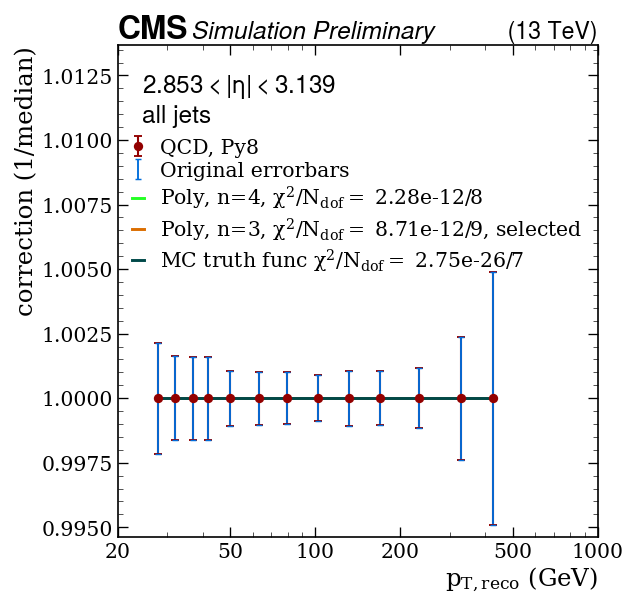

Fitting subsample:  all Eta idx = 8, eta bin = [3.139; 3.489 ]
Using the polinomial n=3 fit results 


/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/anpotreb/ipykernel_21864/164847569.py:11: RuntimeWarning: overflow encountered in exp
  + (p6*np.exp(-p7*((np.log10(x)-p8)*(np.log10(x)-p8))))


Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_all_eta3p139to3p489.pdf / .png


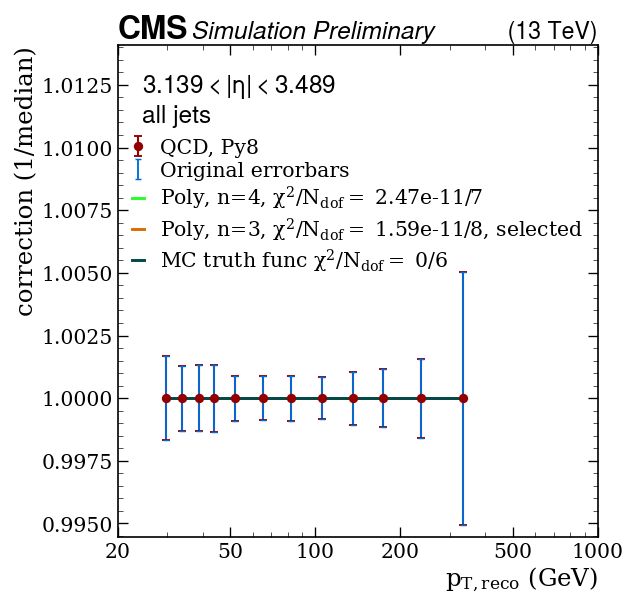

Fitting subsample:  all Eta idx = 9, eta bin = [3.489; 5.191 ]
Using the polinomial n=3 fit results 


/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/anpotreb/ipykernel_21864/164847569.py:11: RuntimeWarning: overflow encountered in exp
  + (p6*np.exp(-p7*((np.log10(x)-p8)*(np.log10(x)-p8))))


Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_all_eta3p489to5p191.pdf / .png


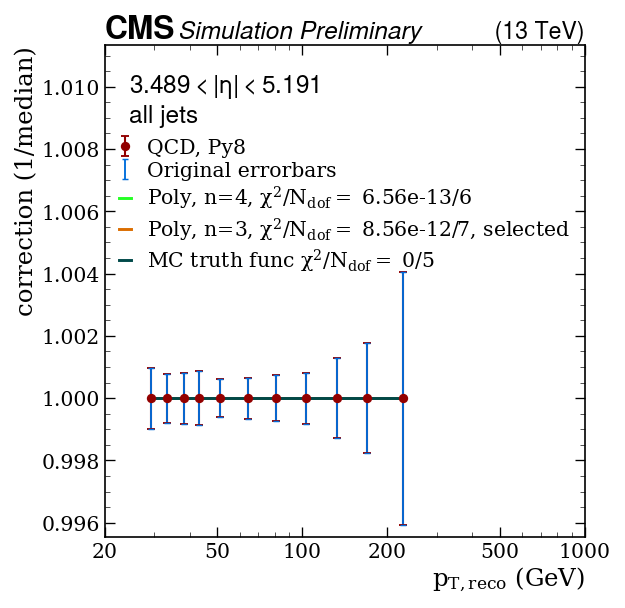

Fitting subsample:  b Eta idx = 0, eta bin = [0.0; 0.783 ]
Winter 14 fit failed
Using the polinomial n=4 fit results 


/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_b_eta0p0to0p783.pdf / .png


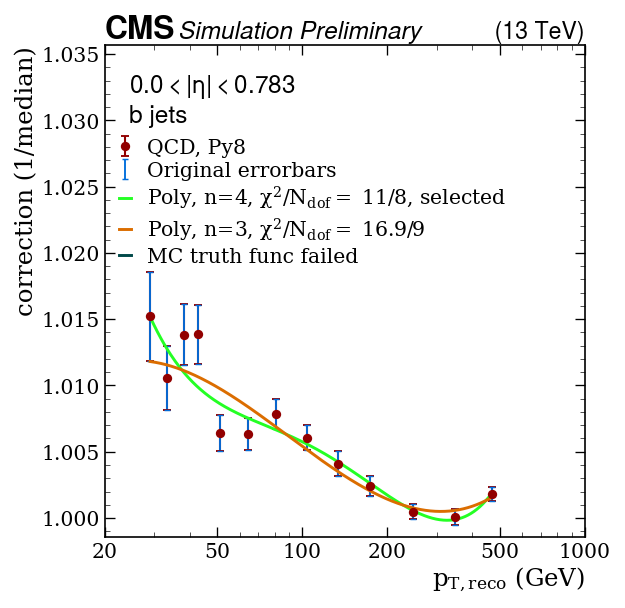

Fitting subsample:  b Eta idx = 1, eta bin = [0.783; 1.305 ]
Winter 14 fit failed
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 
Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_b_eta0p783to1p305.pdf / .png


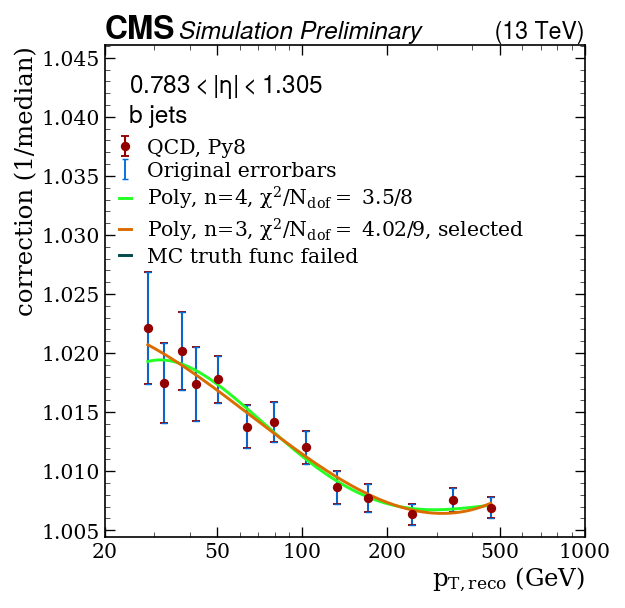

Fitting subsample:  b Eta idx = 2, eta bin = [1.305; 1.653 ]
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 
Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_b_eta1p305to1p653.pdf / .png


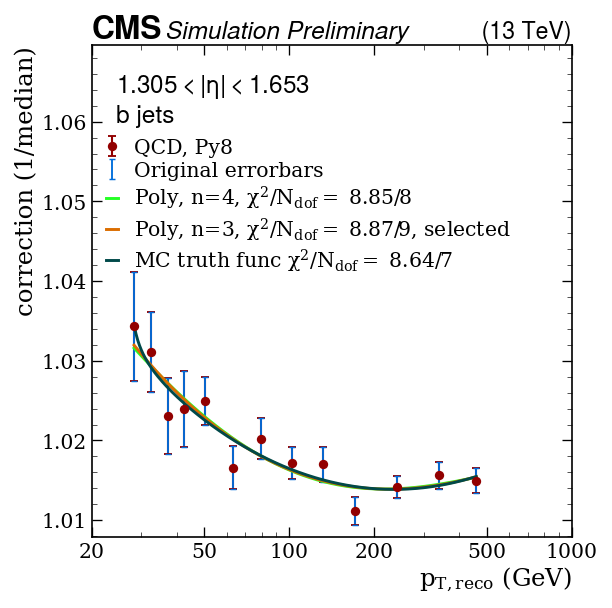

Fitting subsample:  b Eta idx = 3, eta bin = [1.653; 1.93 ]
Winter 14 fit failed
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 


/tmp/anpotreb/ipykernel_21864/164847569.py:11: RuntimeWarning: overflow encountered in exp
  + (p6*np.exp(-p7*((np.log10(x)-p8)*(np.log10(x)-p8))))


Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_b_eta1p653to1p93.pdf / .png


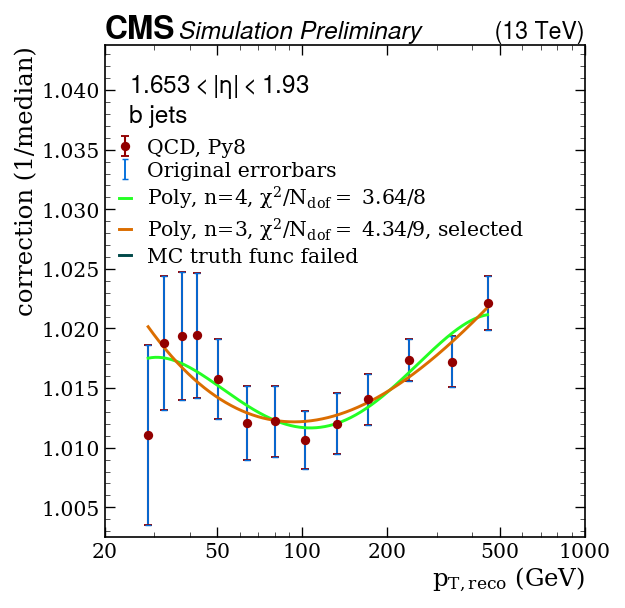

Fitting subsample:  b Eta idx = 4, eta bin = [1.93; 2.322 ]
Winter 14 fit failed
Using the polinomial n=3 fit results 


/tmp/anpotreb/ipykernel_21864/164847569.py:11: RuntimeWarning: overflow encountered in exp
  + (p6*np.exp(-p7*((np.log10(x)-p8)*(np.log10(x)-p8))))
/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_b_eta1p93to2p322.pdf / .png


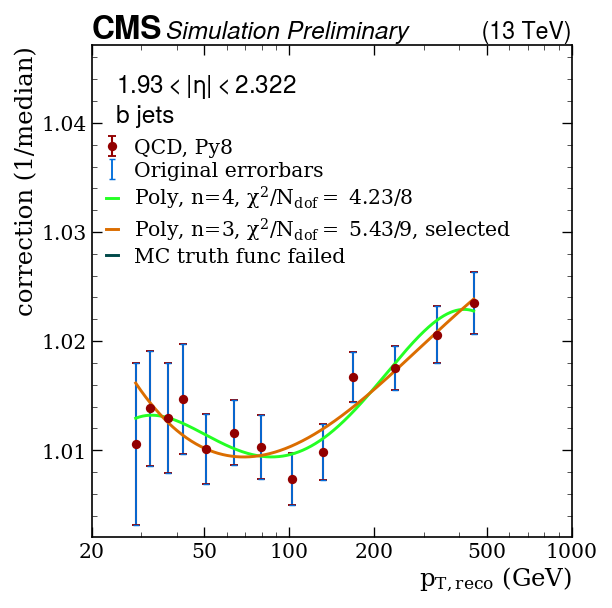

Fitting subsample:  b Eta idx = 5, eta bin = [2.322; 2.5 ]
Winter 14 fit failed
Using the polinomial n=3 fit results 


/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_b_eta2p322to2p5.pdf / .png


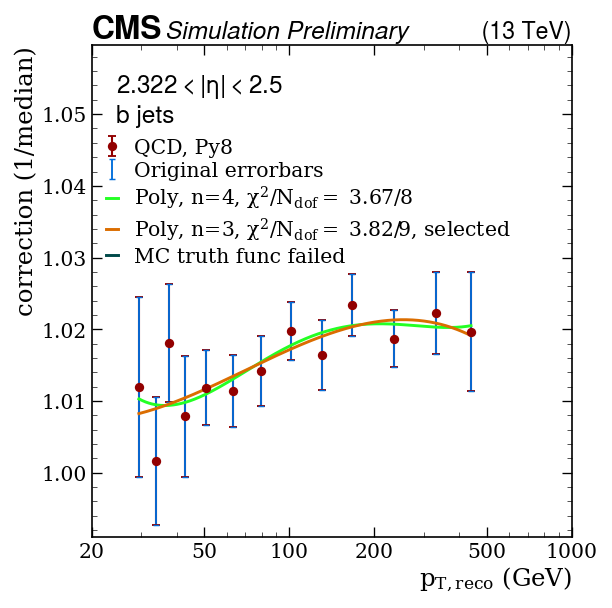

Fitting subsample:  b Eta idx = 6, eta bin = [2.5; 2.853 ]
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 
Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_b_eta2p5to2p853.pdf / .png


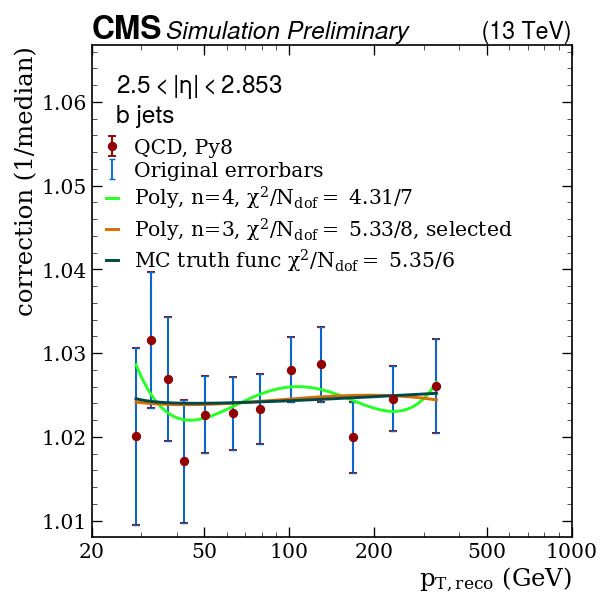

Fitting subsample:  b Eta idx = 7, eta bin = [2.853; 3.139 ]
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 
Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_b_eta2p853to3p139.pdf / .png


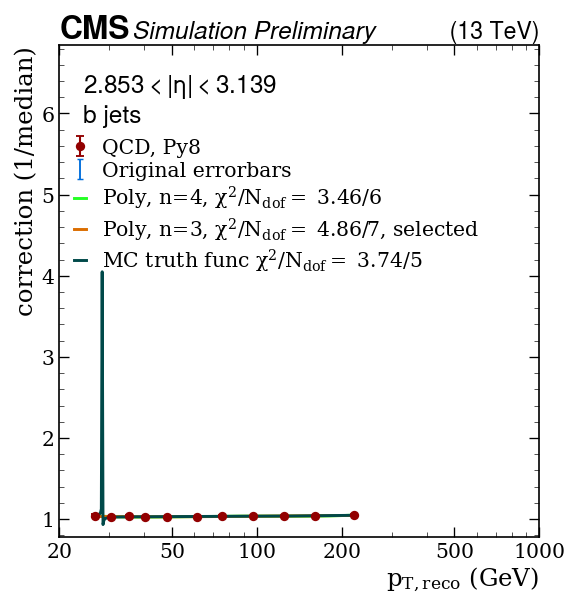

Fitting subsample:  b Eta idx = 8, eta bin = [3.139; 3.489 ]
Winter 14 fit failed
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 


/tmp/anpotreb/ipykernel_21864/164847569.py:11: RuntimeWarning: overflow encountered in exp
  + (p6*np.exp(-p7*((np.log10(x)-p8)*(np.log10(x)-p8))))


Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_b_eta3p139to3p489.pdf / .png


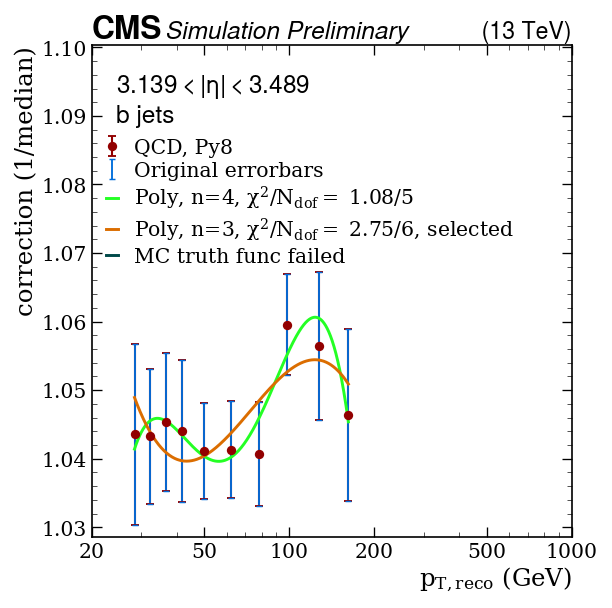

Fitting subsample:  b Eta idx = 9, eta bin = [3.489; 5.191 ]
Too little points for Extended Winter 14 fit
Using the polinomial n=3 fit results 


/tmp/anpotreb/ipykernel_21864/164847569.py:4: RuntimeWarning: overflow encountered in exp
  return p0+(p1/((logx**2)+p2)) + (p3*np.exp(-p4*((logx-p5)*(logx-p5))))


Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_b_eta3p489to5p191.pdf / .png


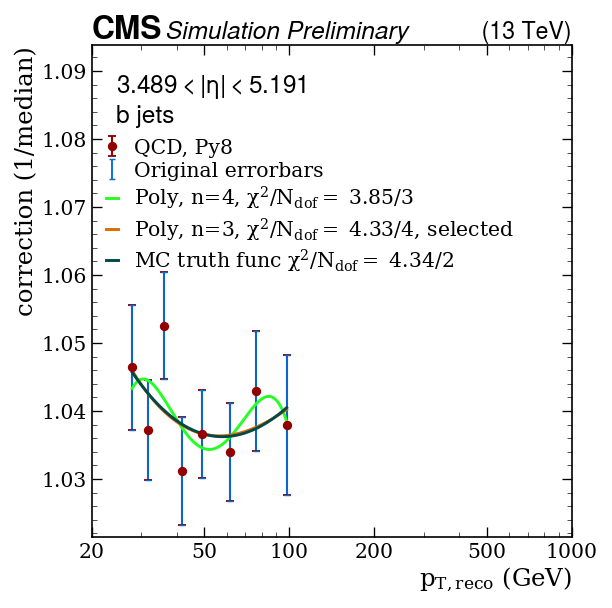

Fitting subsample:  c Eta idx = 0, eta bin = [0.0; 0.783 ]
Winter 14 fit failed
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 
Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_c_eta0p0to0p783.pdf / .png


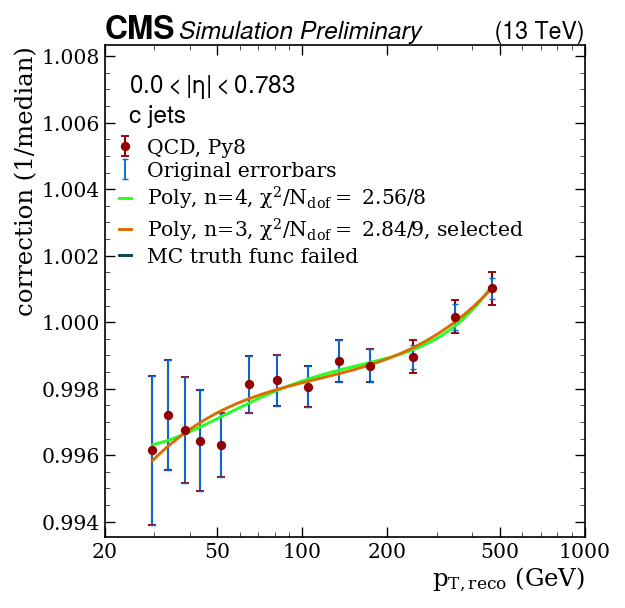

Fitting subsample:  c Eta idx = 1, eta bin = [0.783; 1.305 ]
Winter 14 fit failed
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 
Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_c_eta0p783to1p305.pdf / .png


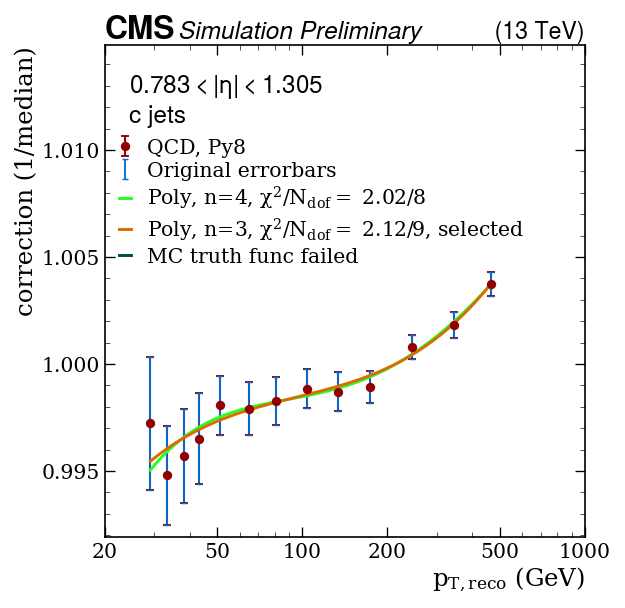

Fitting subsample:  c Eta idx = 2, eta bin = [1.305; 1.653 ]
Winter 14 fit failed
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 
Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_c_eta1p305to1p653.pdf / .png


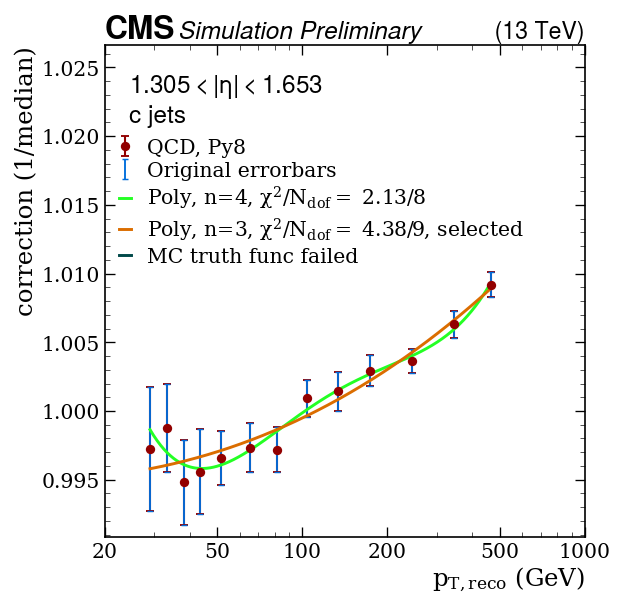

Fitting subsample:  c Eta idx = 3, eta bin = [1.653; 1.93 ]
Winter 14 fit failed
Extended Winter 14 fit failed
Using the polinomial n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_c_eta1p653to1p93.pdf / .png


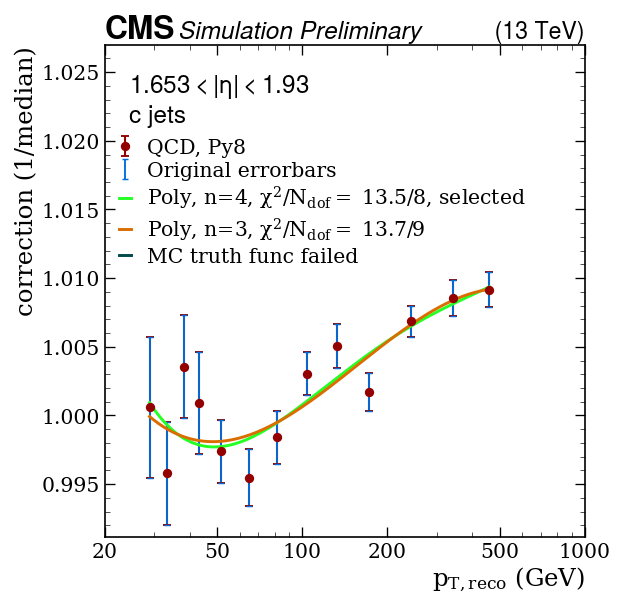

Fitting subsample:  c Eta idx = 4, eta bin = [1.93; 2.322 ]
Winter 14 fit failed
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 


/tmp/anpotreb/ipykernel_21864/164847569.py:11: RuntimeWarning: overflow encountered in exp
  + (p6*np.exp(-p7*((np.log10(x)-p8)*(np.log10(x)-p8))))


Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_c_eta1p93to2p322.pdf / .png


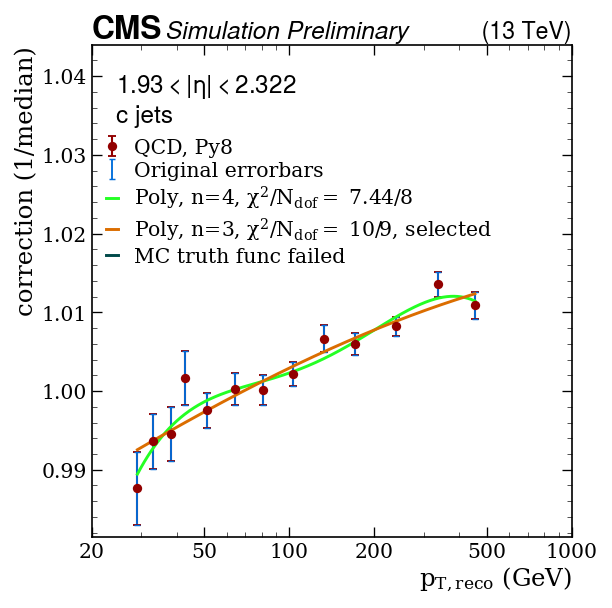

Fitting subsample:  c Eta idx = 5, eta bin = [2.322; 2.5 ]
Winter 14 fit failed
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 


/tmp/anpotreb/ipykernel_21864/164847569.py:11: RuntimeWarning: overflow encountered in exp
  + (p6*np.exp(-p7*((np.log10(x)-p8)*(np.log10(x)-p8))))


Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_c_eta2p322to2p5.pdf / .png


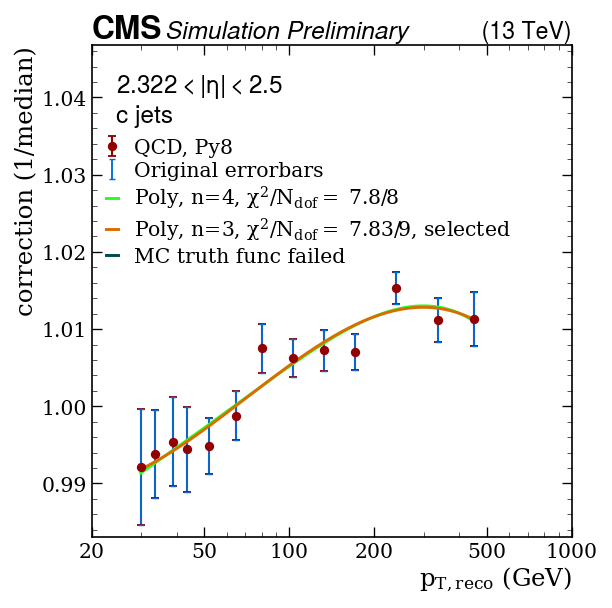

Fitting subsample:  c Eta idx = 6, eta bin = [2.5; 2.853 ]
Winter 14 fit failed
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 
Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_c_eta2p5to2p853.pdf / .png


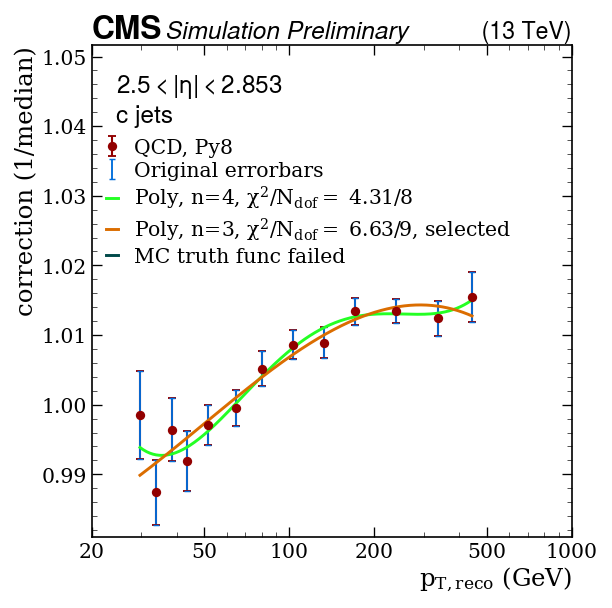

Fitting subsample:  c Eta idx = 7, eta bin = [2.853; 3.139 ]
Winter 14 fit failed
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 
Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_c_eta2p853to3p139.pdf / .png


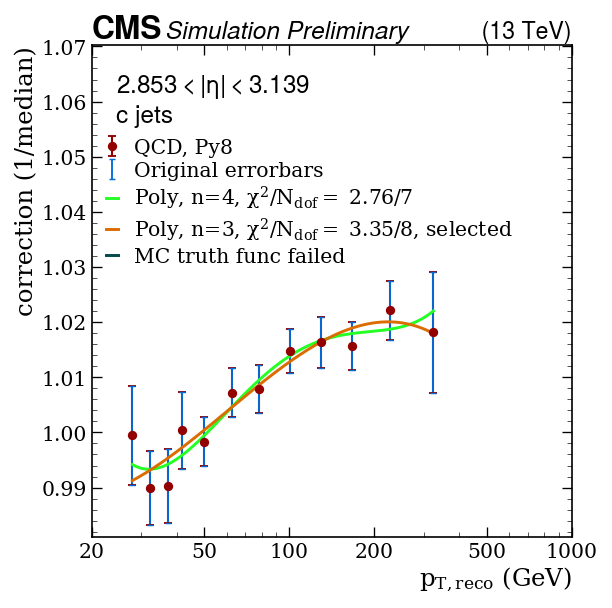

Fitting subsample:  c Eta idx = 8, eta bin = [3.139; 3.489 ]
Winter 14 fit failed
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 
Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_c_eta3p139to3p489.pdf / .png


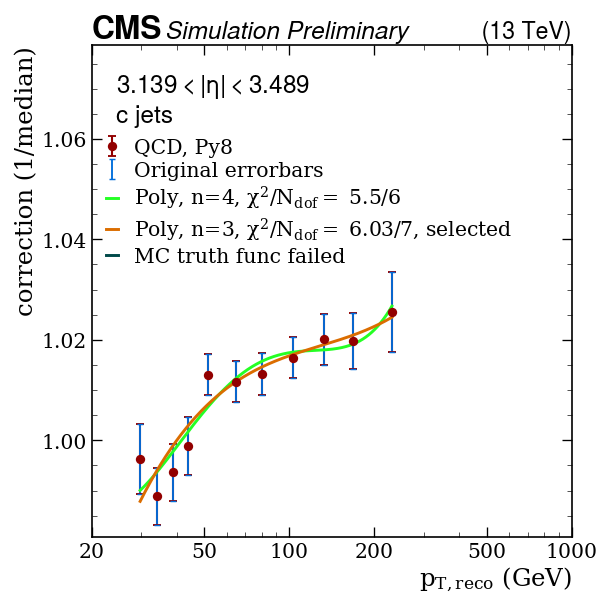

Fitting subsample:  c Eta idx = 9, eta bin = [3.489; 5.191 ]
Winter 14 fit failed
Using the polinomial n=3 fit results 


/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_c_eta3p489to5p191.pdf / .png


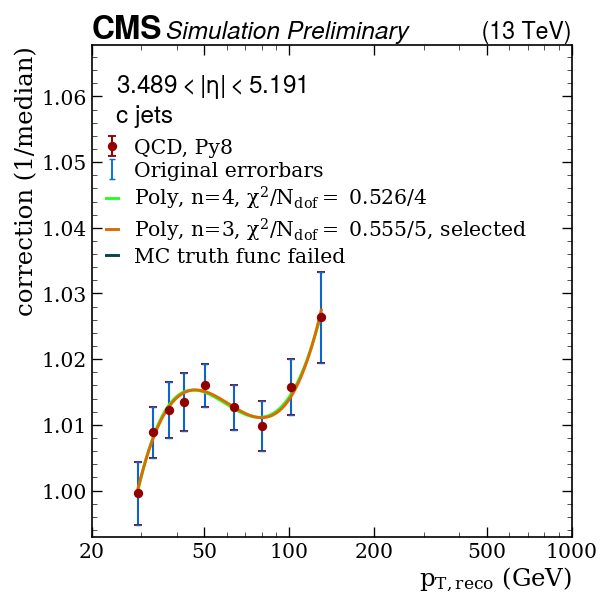

Fitting subsample:  u Eta idx = 0, eta bin = [0.0; 0.783 ]
Using the polinomial n=3 fit results 


/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_u_eta0p0to0p783.pdf / .png


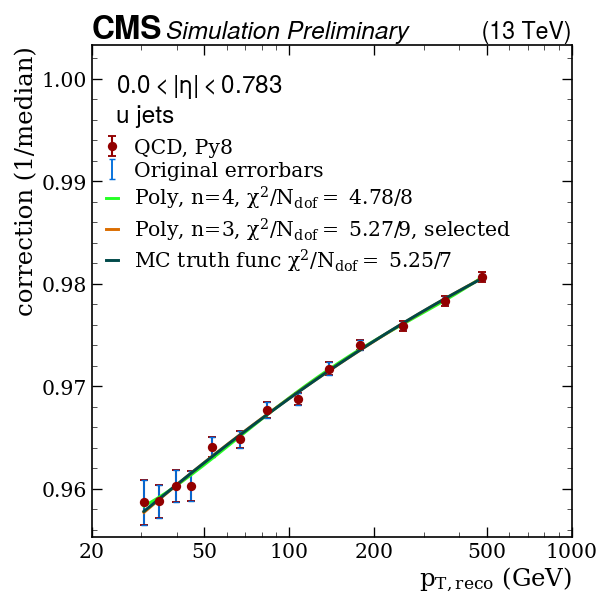

Fitting subsample:  u Eta idx = 1, eta bin = [0.783; 1.305 ]
Winter 14 fit failed
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 
Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_u_eta0p783to1p305.pdf / .png


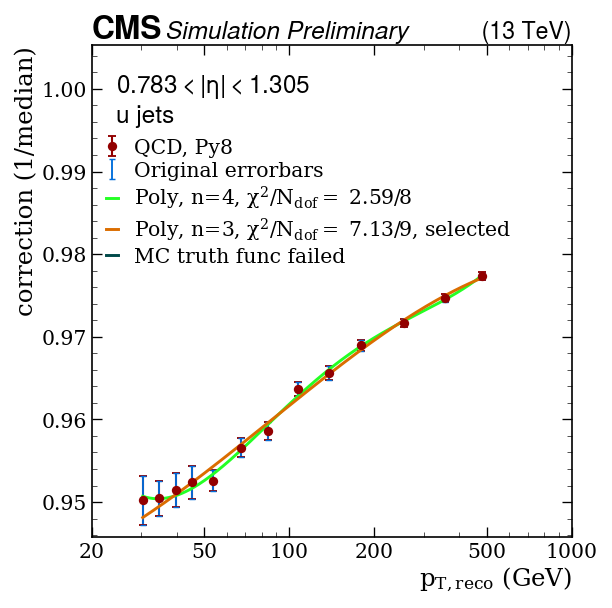

Fitting subsample:  u Eta idx = 2, eta bin = [1.305; 1.653 ]
Winter 14 fit failed
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 
Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_u_eta1p305to1p653.pdf / .png


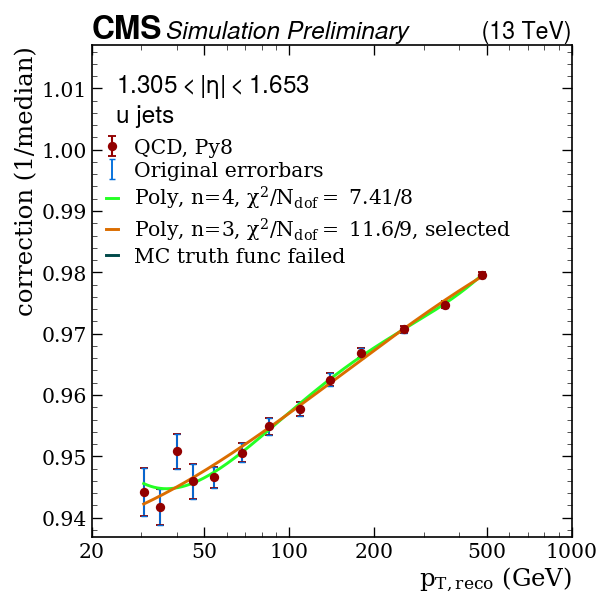

Fitting subsample:  u Eta idx = 3, eta bin = [1.653; 1.93 ]
Winter 14 fit failed
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 


/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_u_eta1p653to1p93.pdf / .png


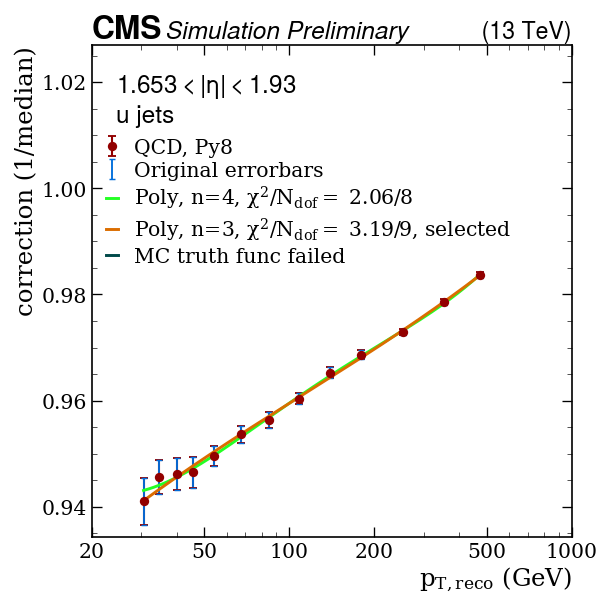

Fitting subsample:  u Eta idx = 4, eta bin = [1.93; 2.322 ]
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 
Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_u_eta1p93to2p322.pdf / .png


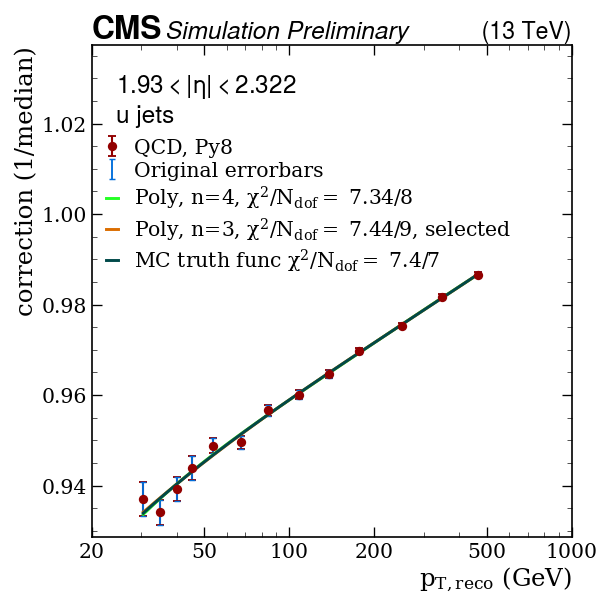

Fitting subsample:  u Eta idx = 5, eta bin = [2.322; 2.5 ]
Winter 14 fit failed
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 


/tmp/anpotreb/ipykernel_21864/164847569.py:11: RuntimeWarning: overflow encountered in exp
  + (p6*np.exp(-p7*((np.log10(x)-p8)*(np.log10(x)-p8))))


Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_u_eta2p322to2p5.pdf / .png


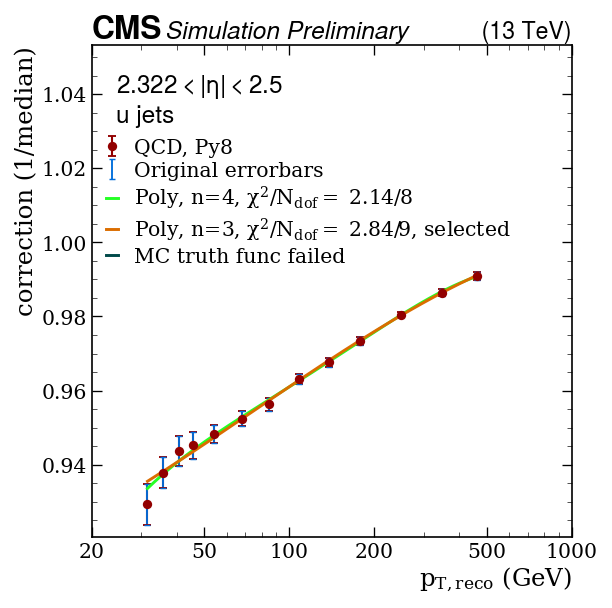

Fitting subsample:  u Eta idx = 6, eta bin = [2.5; 2.853 ]
Winter 14 fit failed
Using the polinomial n=3 fit results 


/tmp/anpotreb/ipykernel_21864/164847569.py:11: RuntimeWarning: overflow encountered in exp
  + (p6*np.exp(-p7*((np.log10(x)-p8)*(np.log10(x)-p8))))
/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/anpotreb/ipykernel_21864/164847569.py:10: RuntimeWarning: overflow encountered in exp
  + (p3*np.exp(-p4*((np.log10(x)-p5)*(np.log10(x)-p5))))


Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_u_eta2p5to2p853.pdf / .png


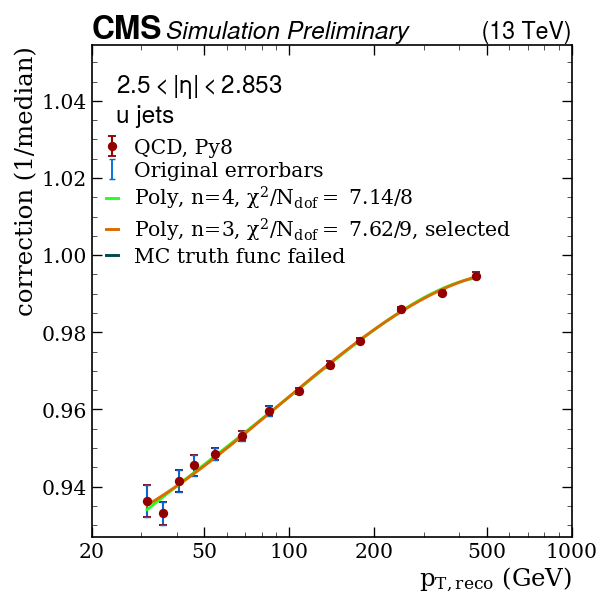

Fitting subsample:  u Eta idx = 7, eta bin = [2.853; 3.139 ]
Winter 14 fit failed
Using the polinomial n=3 fit results 


/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_u_eta2p853to3p139.pdf / .png


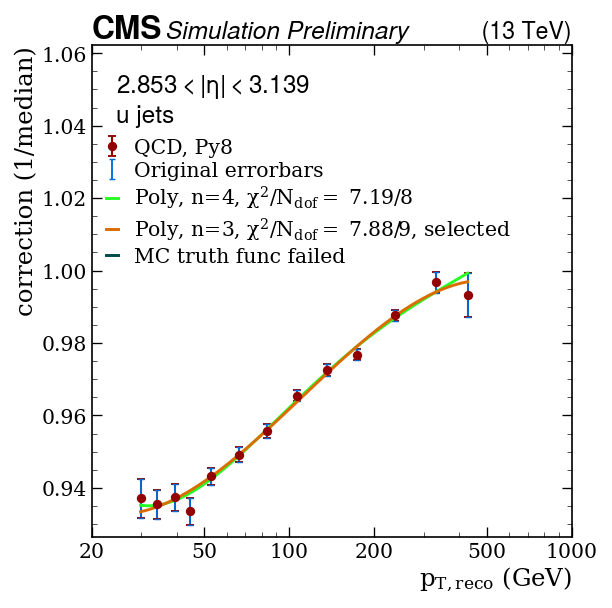

Fitting subsample:  u Eta idx = 8, eta bin = [3.139; 3.489 ]
Winter 14 fit failed
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 
Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_u_eta3p139to3p489.pdf / .png


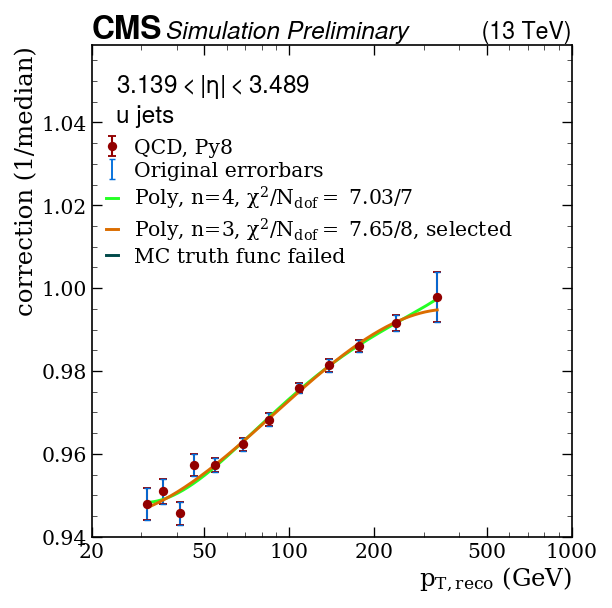

Fitting subsample:  u Eta idx = 9, eta bin = [3.489; 5.191 ]
Winter 14 fit failed
Using the polinomial n=3 fit results 


/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_u_eta3p489to5p191.pdf / .png


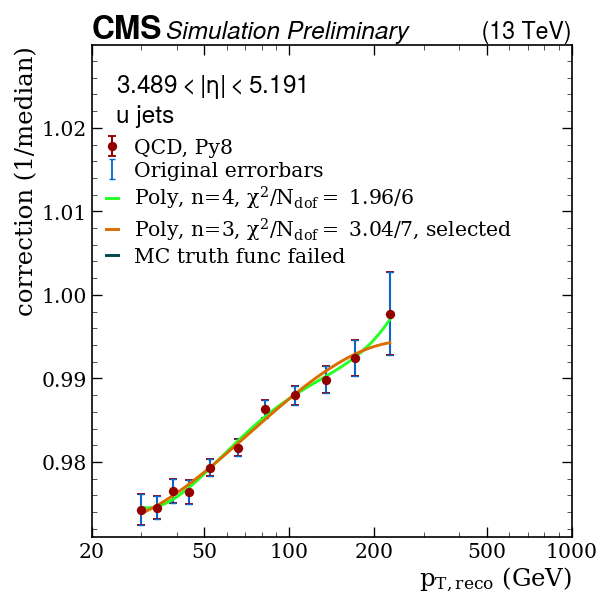

Fitting subsample:  d Eta idx = 0, eta bin = [0.0; 0.783 ]
Winter 14 fit failed
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 


/tmp/anpotreb/ipykernel_21864/164847569.py:11: RuntimeWarning: overflow encountered in exp
  + (p6*np.exp(-p7*((np.log10(x)-p8)*(np.log10(x)-p8))))


Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_d_eta0p0to0p783.pdf / .png


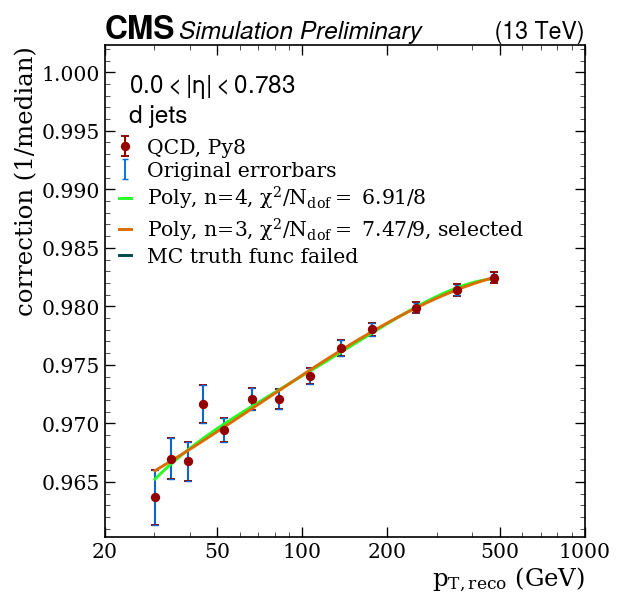

Fitting subsample:  d Eta idx = 1, eta bin = [0.783; 1.305 ]
Winter 14 fit failed
Using the polinomial n=3 fit results 


/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_d_eta0p783to1p305.pdf / .png


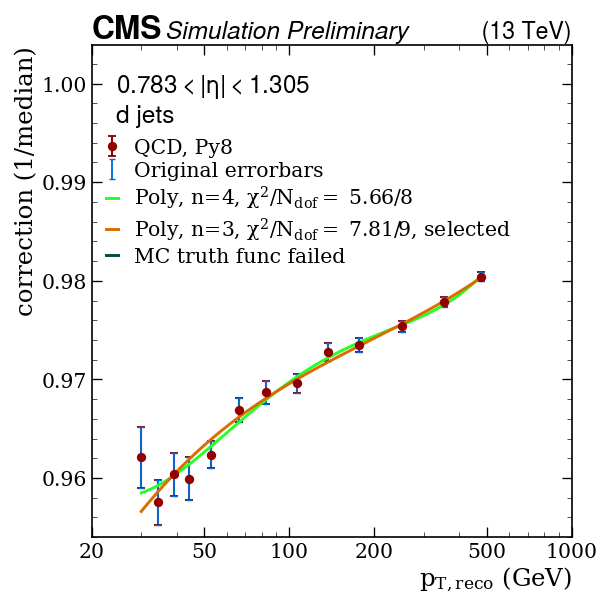

Fitting subsample:  d Eta idx = 2, eta bin = [1.305; 1.653 ]
Winter 14 fit failed
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 


/tmp/anpotreb/ipykernel_21864/164847569.py:11: RuntimeWarning: overflow encountered in exp
  + (p6*np.exp(-p7*((np.log10(x)-p8)*(np.log10(x)-p8))))


Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_d_eta1p305to1p653.pdf / .png


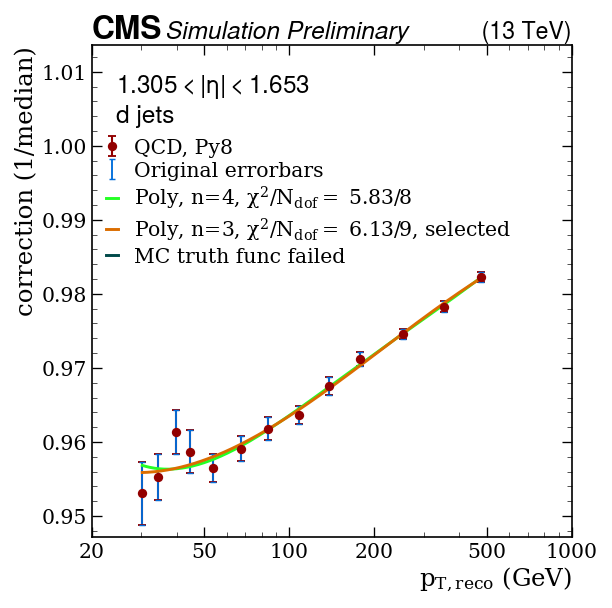

Fitting subsample:  d Eta idx = 3, eta bin = [1.653; 1.93 ]
Winter 14 fit failed
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 


/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_d_eta1p653to1p93.pdf / .png


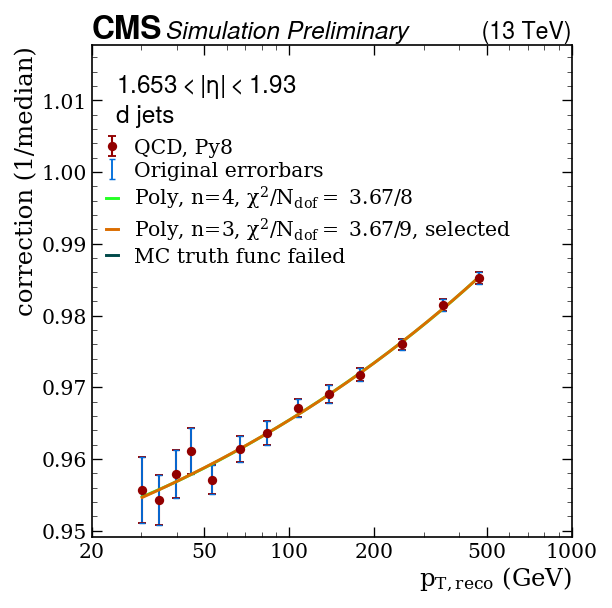

Fitting subsample:  d Eta idx = 4, eta bin = [1.93; 2.322 ]
Using the polinomial n=3 fit results 


/tmp/anpotreb/ipykernel_21864/164847569.py:11: RuntimeWarning: overflow encountered in exp
  + (p6*np.exp(-p7*((np.log10(x)-p8)*(np.log10(x)-p8))))
/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_d_eta1p93to2p322.pdf / .png


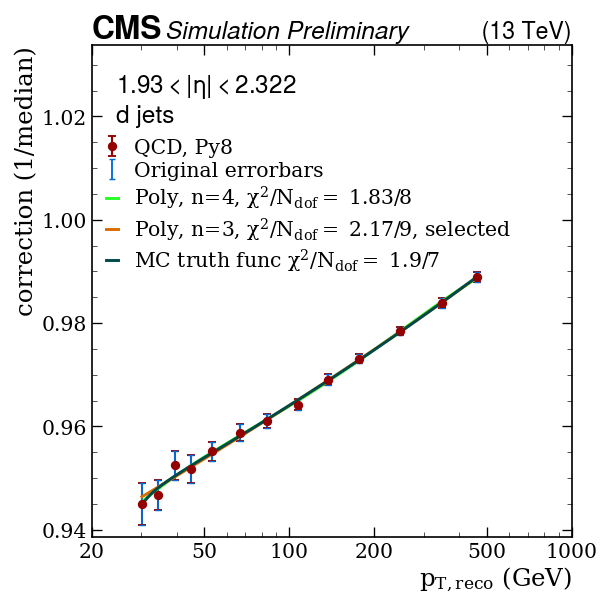

Fitting subsample:  d Eta idx = 5, eta bin = [2.322; 2.5 ]
Winter 14 fit failed
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 


/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/anpotreb/ipykernel_21864/164847569.py:10: RuntimeWarning: overflow encountered in exp
  + (p3*np.exp(-p4*((np.log10(x)-p5)*(np.log10(x)-p5))))


Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_d_eta2p322to2p5.pdf / .png


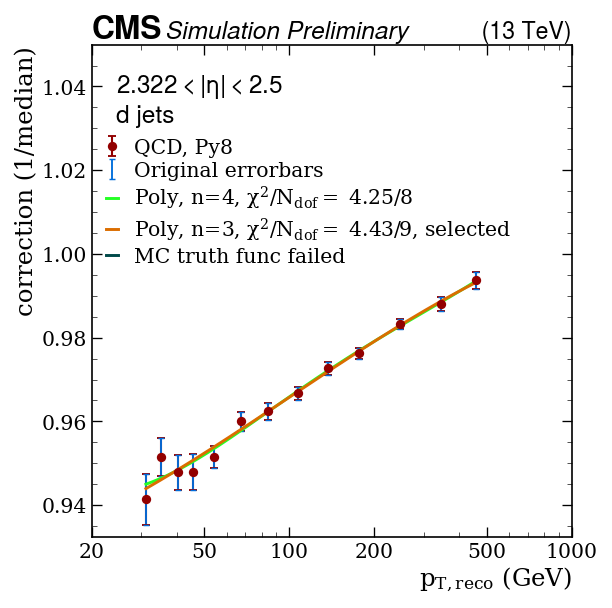

Fitting subsample:  d Eta idx = 6, eta bin = [2.5; 2.853 ]
Winter 14 fit failed
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 
Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_d_eta2p5to2p853.pdf / .png


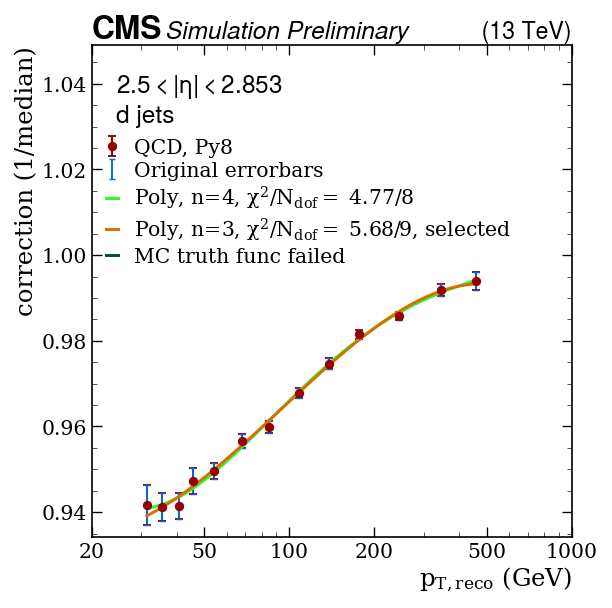

Fitting subsample:  d Eta idx = 7, eta bin = [2.853; 3.139 ]
Winter 14 fit failed
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 


/tmp/anpotreb/ipykernel_21864/164847569.py:11: RuntimeWarning: overflow encountered in exp
  + (p6*np.exp(-p7*((np.log10(x)-p8)*(np.log10(x)-p8))))


Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_d_eta2p853to3p139.pdf / .png


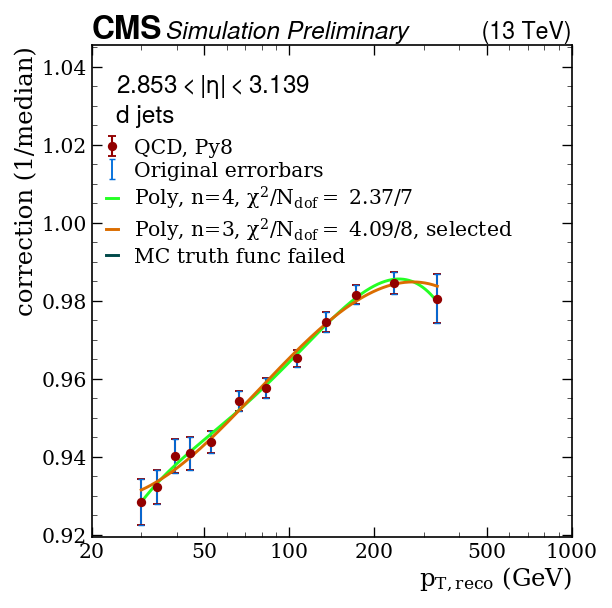

Fitting subsample:  d Eta idx = 8, eta bin = [3.139; 3.489 ]
Winter 14 fit failed
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 
Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_d_eta3p139to3p489.pdf / .png


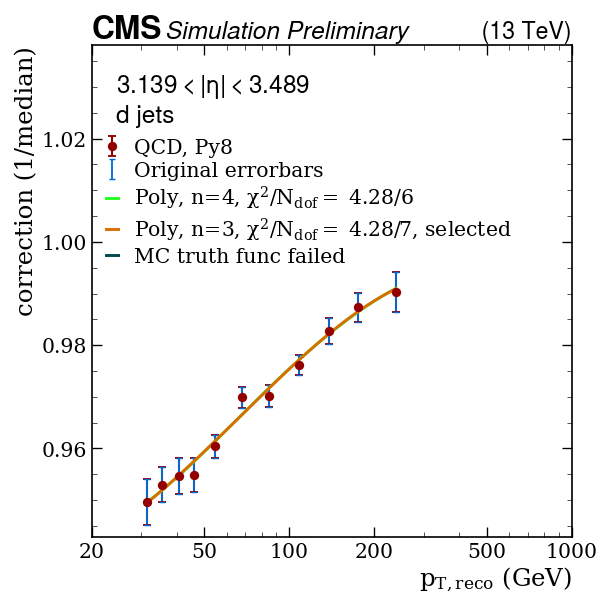

Fitting subsample:  d Eta idx = 9, eta bin = [3.489; 5.191 ]
Winter 14 fit failed
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 


/tmp/anpotreb/ipykernel_21864/164847569.py:11: RuntimeWarning: overflow encountered in exp
  + (p6*np.exp(-p7*((np.log10(x)-p8)*(np.log10(x)-p8))))


Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_d_eta3p489to5p191.pdf / .png


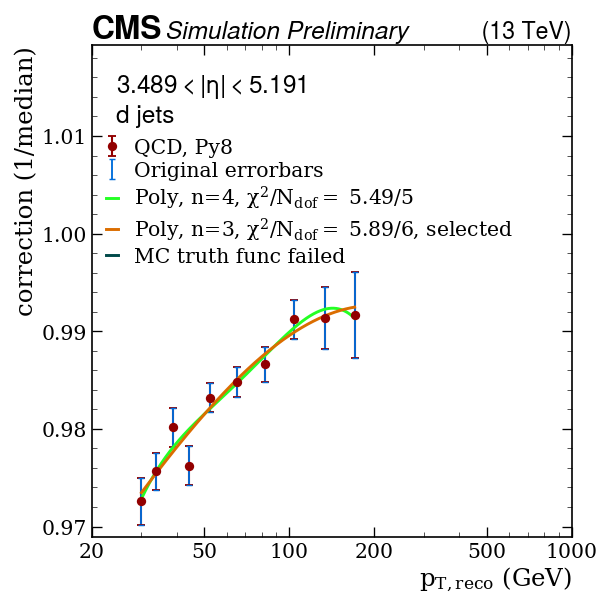

Fitting subsample:  g Eta idx = 0, eta bin = [0.0; 0.783 ]
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 
Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_g_eta0p0to0p783.pdf / .png


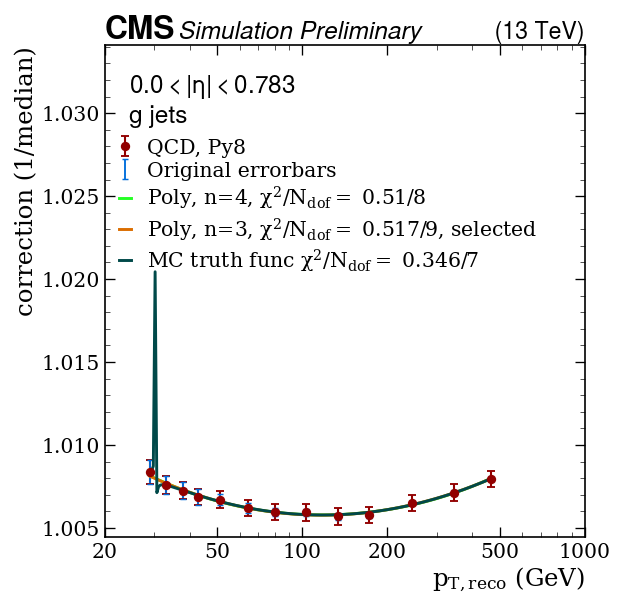

Fitting subsample:  g Eta idx = 1, eta bin = [0.783; 1.305 ]
Winter 14 fit failed
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 


/tmp/anpotreb/ipykernel_21864/164847569.py:11: RuntimeWarning: overflow encountered in exp
  + (p6*np.exp(-p7*((np.log10(x)-p8)*(np.log10(x)-p8))))


Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_g_eta0p783to1p305.pdf / .png


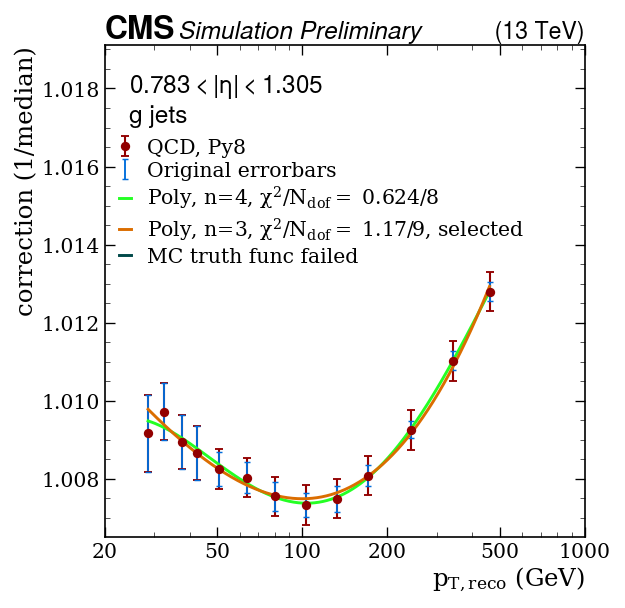

Fitting subsample:  g Eta idx = 2, eta bin = [1.305; 1.653 ]
Winter 14 fit failed
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 


/tmp/anpotreb/ipykernel_21864/164847569.py:11: RuntimeWarning: overflow encountered in exp
  + (p6*np.exp(-p7*((np.log10(x)-p8)*(np.log10(x)-p8))))


Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_g_eta1p305to1p653.pdf / .png


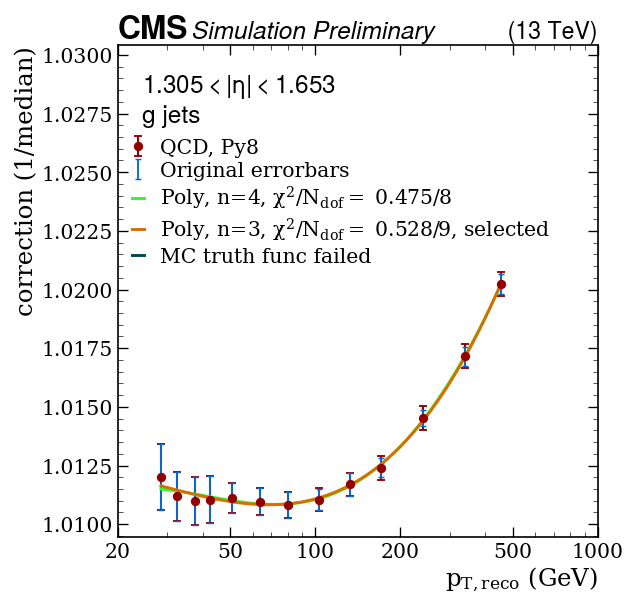

Fitting subsample:  g Eta idx = 3, eta bin = [1.653; 1.93 ]
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 


/tmp/anpotreb/ipykernel_21864/164847569.py:11: RuntimeWarning: overflow encountered in exp
  + (p6*np.exp(-p7*((np.log10(x)-p8)*(np.log10(x)-p8))))


Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_g_eta1p653to1p93.pdf / .png


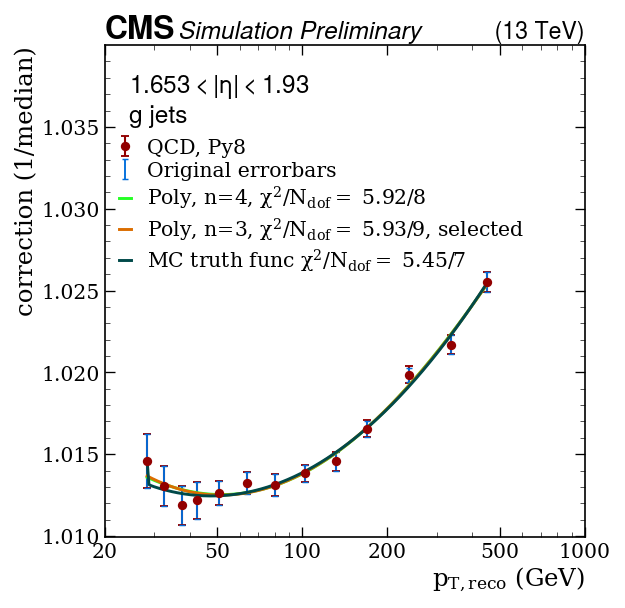

Fitting subsample:  g Eta idx = 4, eta bin = [1.93; 2.322 ]
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 
Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_g_eta1p93to2p322.pdf / .png


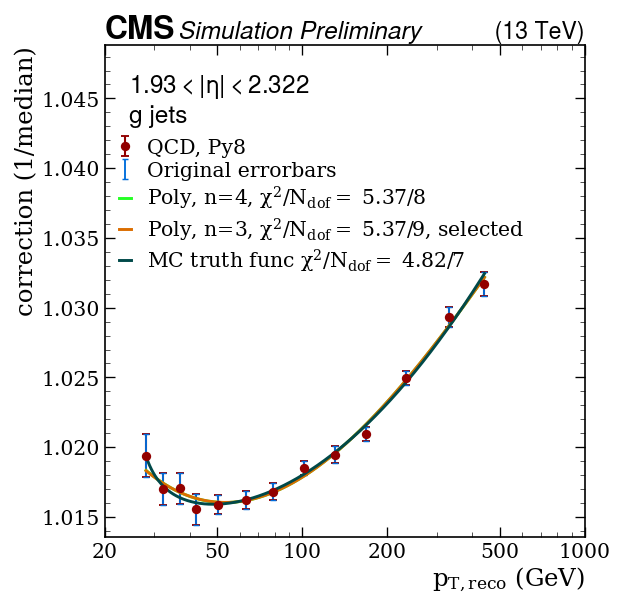

Fitting subsample:  g Eta idx = 5, eta bin = [2.322; 2.5 ]
Winter 14 fit failed
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 
Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_g_eta2p322to2p5.pdf / .png


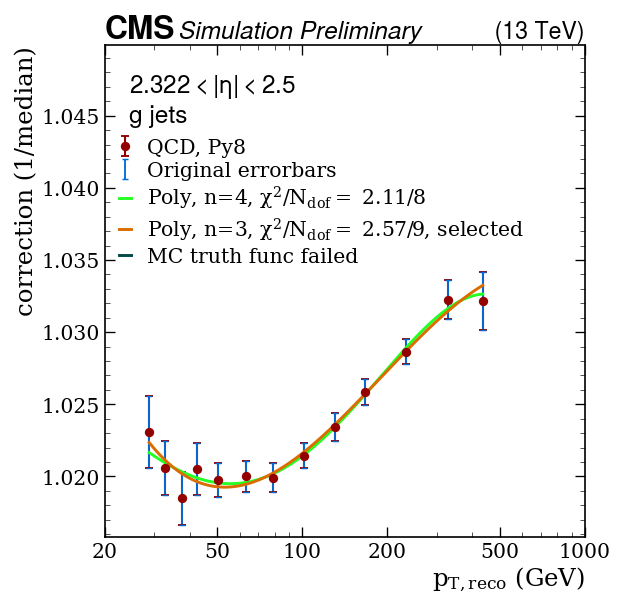

Fitting subsample:  g Eta idx = 6, eta bin = [2.5; 2.853 ]
Winter 14 fit failed
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 
Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_g_eta2p5to2p853.pdf / .png


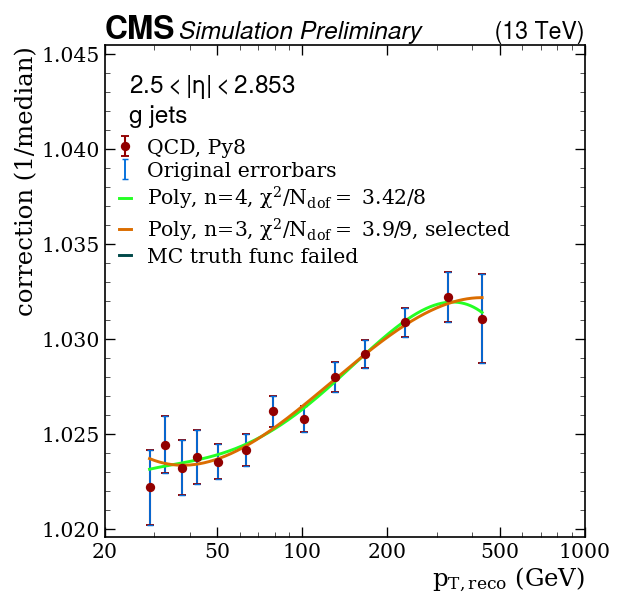

Fitting subsample:  g Eta idx = 7, eta bin = [2.853; 3.139 ]
Winter 14 fit failed
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 


/tmp/anpotreb/ipykernel_21864/164847569.py:11: RuntimeWarning: overflow encountered in exp
  + (p6*np.exp(-p7*((np.log10(x)-p8)*(np.log10(x)-p8))))


Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_g_eta2p853to3p139.pdf / .png


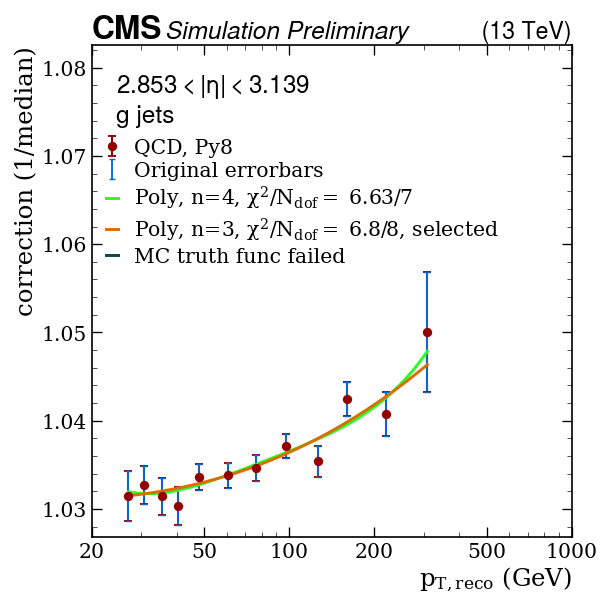

Fitting subsample:  g Eta idx = 8, eta bin = [3.139; 3.489 ]
Winter 14 fit failed
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 
Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_g_eta3p139to3p489.pdf / .png


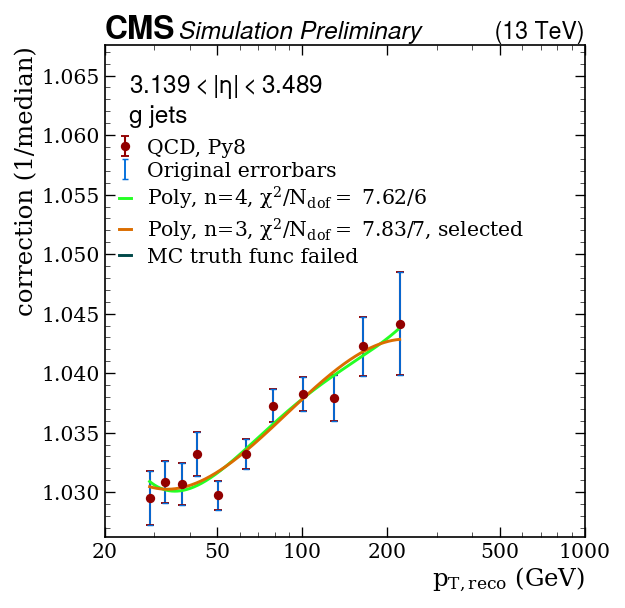

Fitting subsample:  g Eta idx = 9, eta bin = [3.489; 5.191 ]
Winter 14 fit failed
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 
Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_g_eta3p489to5p191.pdf / .png


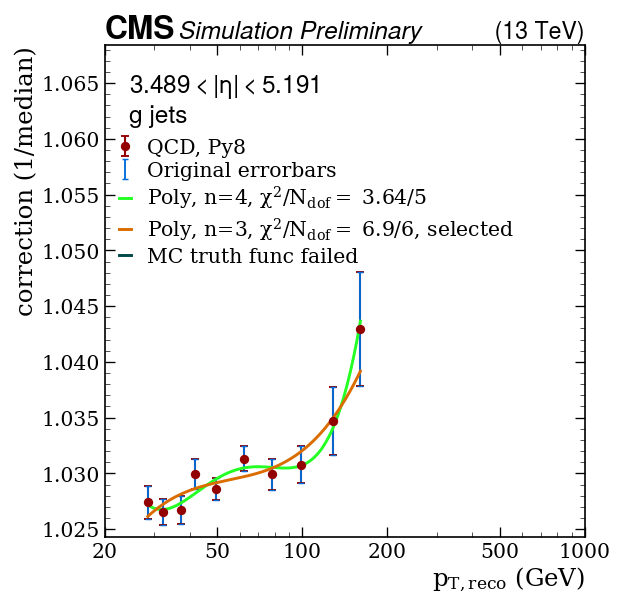

Fitting subsample:  s Eta idx = 0, eta bin = [0.0; 0.783 ]
Winter 14 fit failed
Using the polinomial n=3 fit results 


/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_s_eta0p0to0p783.pdf / .png


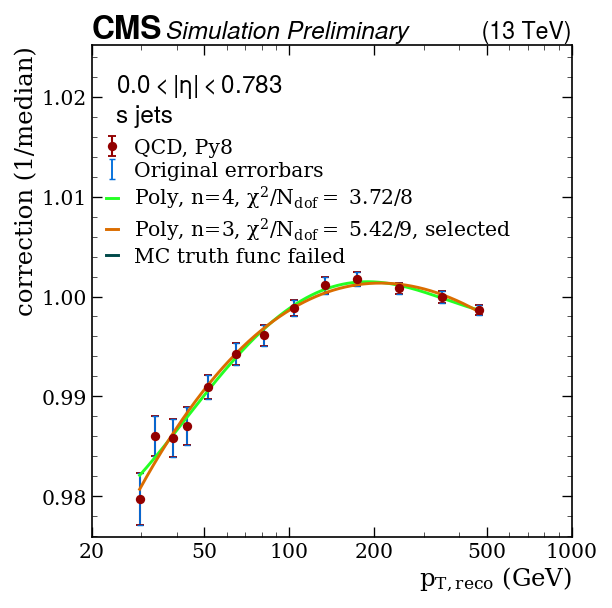

Fitting subsample:  s Eta idx = 1, eta bin = [0.783; 1.305 ]
Winter 14 fit failed
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 


/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_s_eta0p783to1p305.pdf / .png


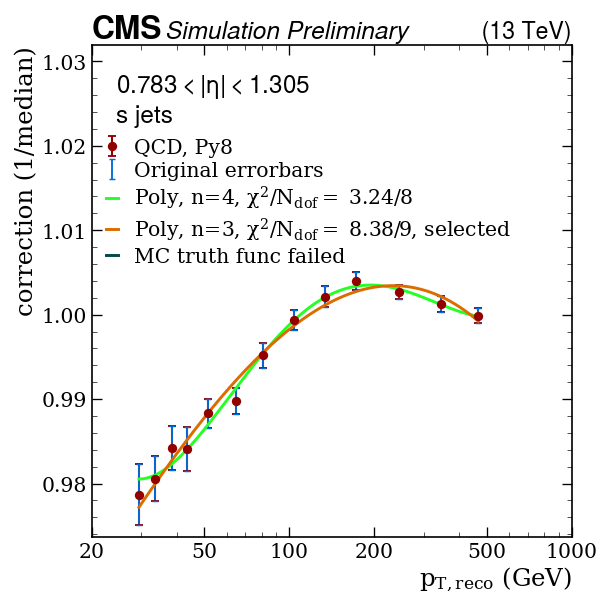

Fitting subsample:  s Eta idx = 2, eta bin = [1.305; 1.653 ]
Winter 14 fit failed
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 
Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_s_eta1p305to1p653.pdf / .png


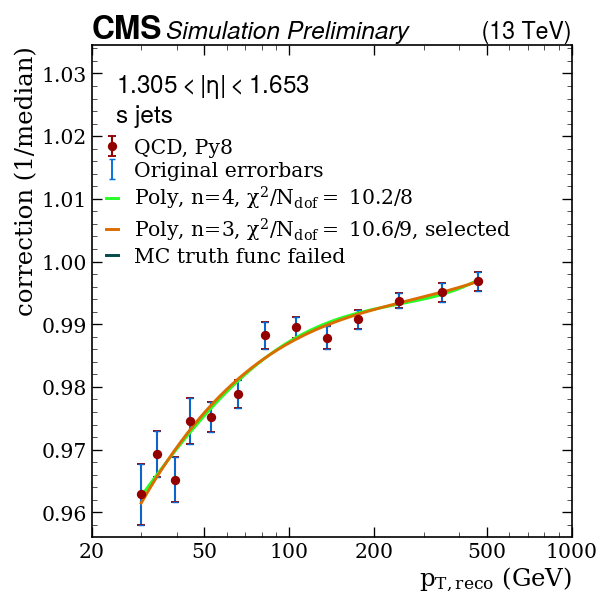

Fitting subsample:  s Eta idx = 3, eta bin = [1.653; 1.93 ]
Winter 14 fit failed
Using the polinomial n=3 fit results 


/tmp/anpotreb/ipykernel_21864/164847569.py:10: RuntimeWarning: overflow encountered in exp
  + (p3*np.exp(-p4*((np.log10(x)-p5)*(np.log10(x)-p5))))


Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_s_eta1p653to1p93.pdf / .png


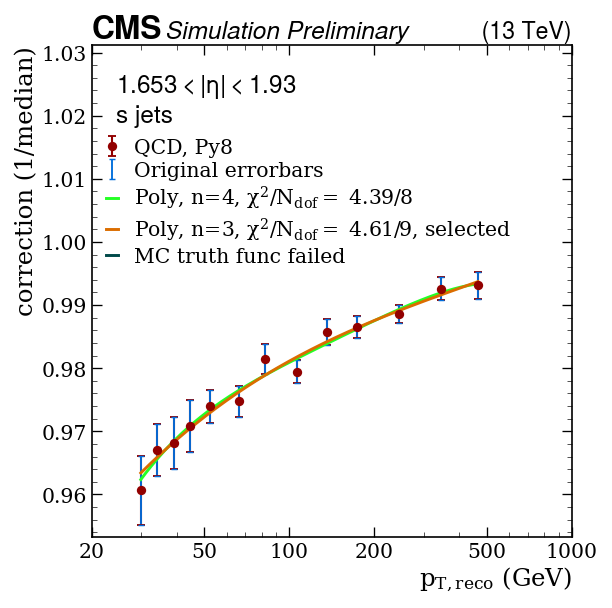

Fitting subsample:  s Eta idx = 4, eta bin = [1.93; 2.322 ]
Winter 14 fit failed
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 


/tmp/anpotreb/ipykernel_21864/164847569.py:11: RuntimeWarning: overflow encountered in exp
  + (p6*np.exp(-p7*((np.log10(x)-p8)*(np.log10(x)-p8))))


Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_s_eta1p93to2p322.pdf / .png


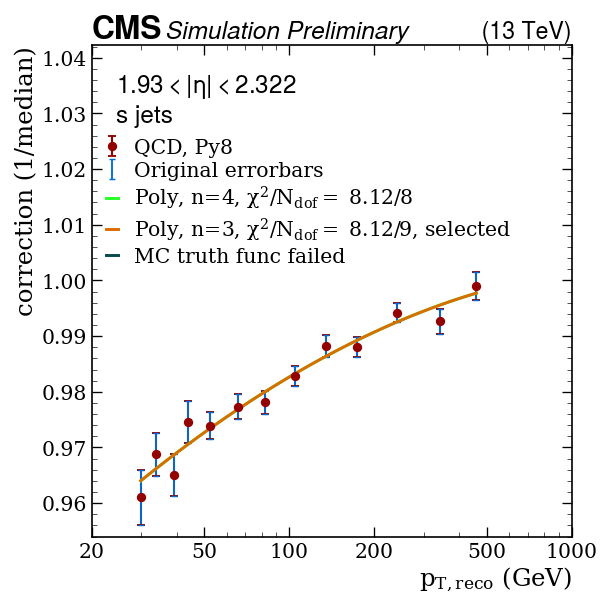

Fitting subsample:  s Eta idx = 5, eta bin = [2.322; 2.5 ]
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 
Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_s_eta2p322to2p5.pdf / .png


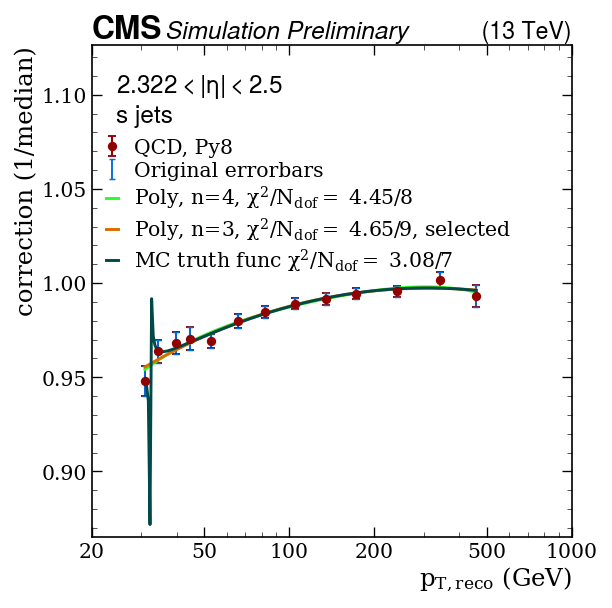

Fitting subsample:  s Eta idx = 6, eta bin = [2.5; 2.853 ]
Winter 14 fit failed
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 


/tmp/anpotreb/ipykernel_21864/164847569.py:11: RuntimeWarning: overflow encountered in exp
  + (p6*np.exp(-p7*((np.log10(x)-p8)*(np.log10(x)-p8))))


Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_s_eta2p5to2p853.pdf / .png


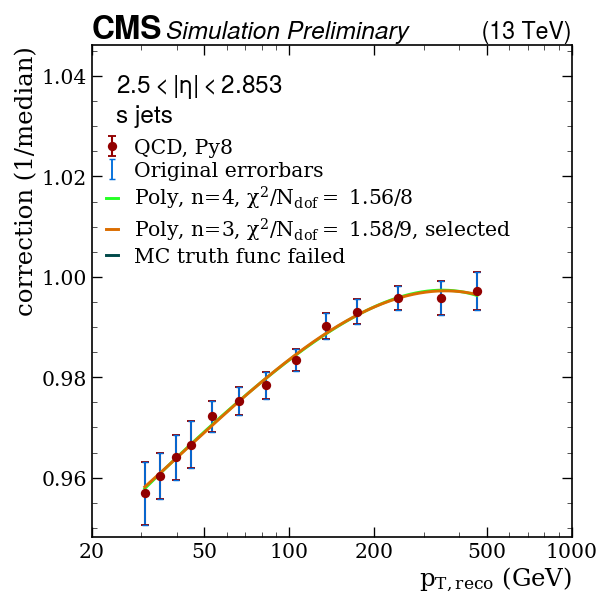

Fitting subsample:  s Eta idx = 7, eta bin = [2.853; 3.139 ]
Winter 14 fit failed
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 


/tmp/anpotreb/ipykernel_21864/164847569.py:11: RuntimeWarning: overflow encountered in exp
  + (p6*np.exp(-p7*((np.log10(x)-p8)*(np.log10(x)-p8))))


Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_s_eta2p853to3p139.pdf / .png


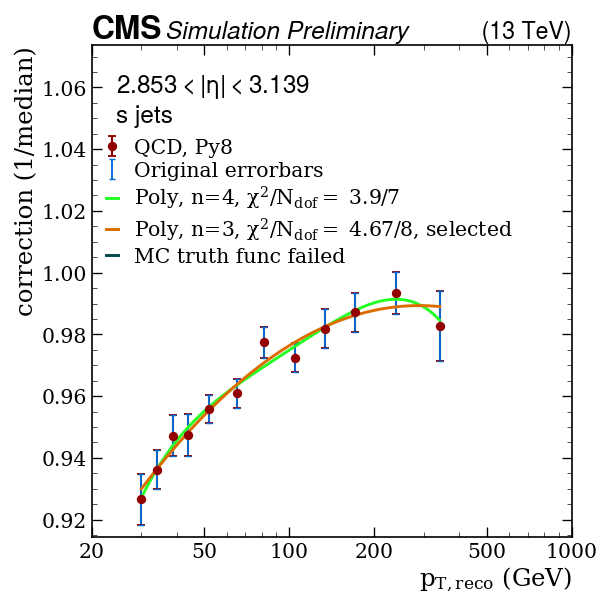

Fitting subsample:  s Eta idx = 8, eta bin = [3.139; 3.489 ]
Winter 14 fit failed
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 


/tmp/anpotreb/ipykernel_21864/164847569.py:11: RuntimeWarning: overflow encountered in exp
  + (p6*np.exp(-p7*((np.log10(x)-p8)*(np.log10(x)-p8))))


Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_s_eta3p139to3p489.pdf / .png


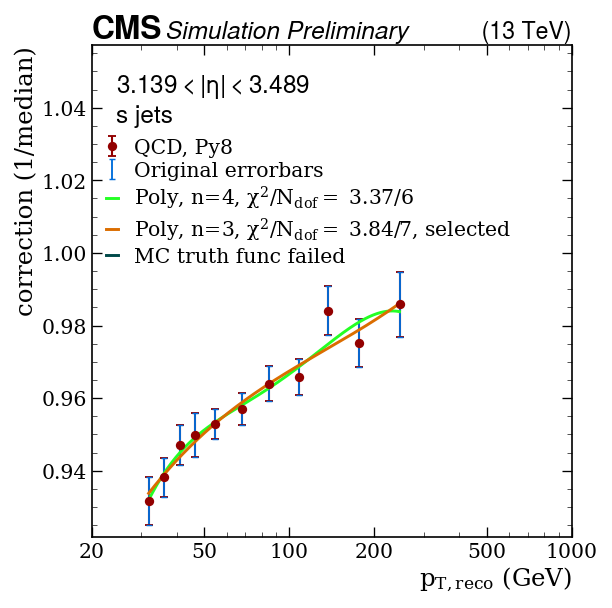

Fitting subsample:  s Eta idx = 9, eta bin = [3.489; 5.191 ]
Winter 14 fit failed
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 
Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_s_eta3p489to5p191.pdf / .png


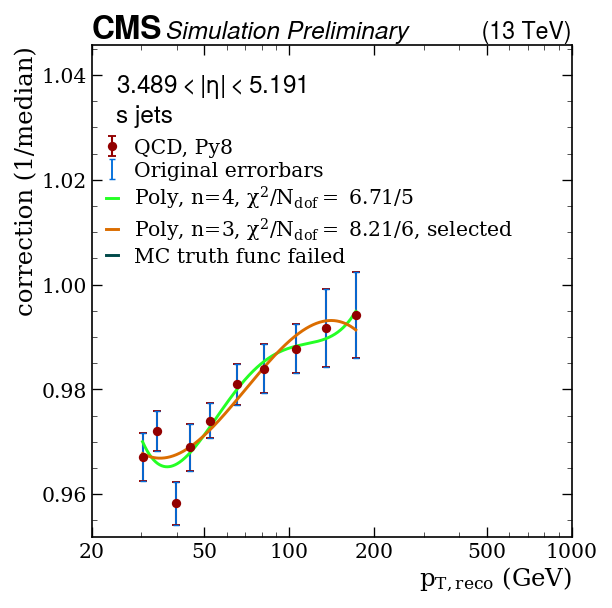

Fitting subsample:  ud Eta idx = 0, eta bin = [0.0; 0.783 ]
Winter 14 fit failed
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 
Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_ud_eta0p0to0p783.pdf / .png


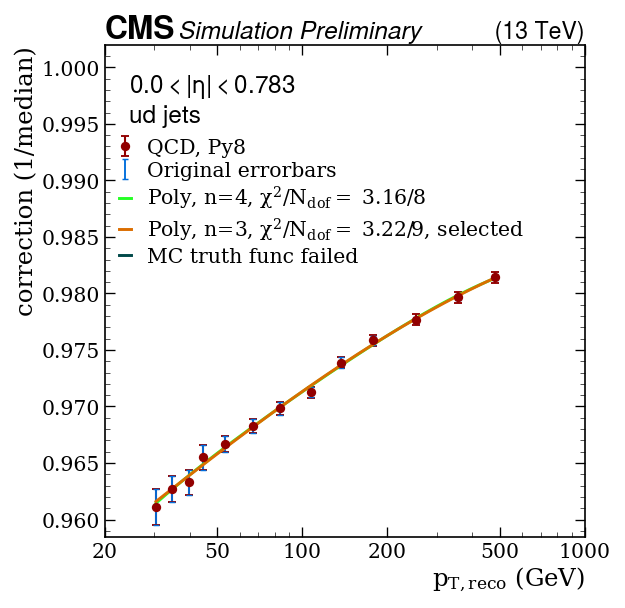

Fitting subsample:  ud Eta idx = 1, eta bin = [0.783; 1.305 ]
Winter 14 fit failed
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 
Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_ud_eta0p783to1p305.pdf / .png


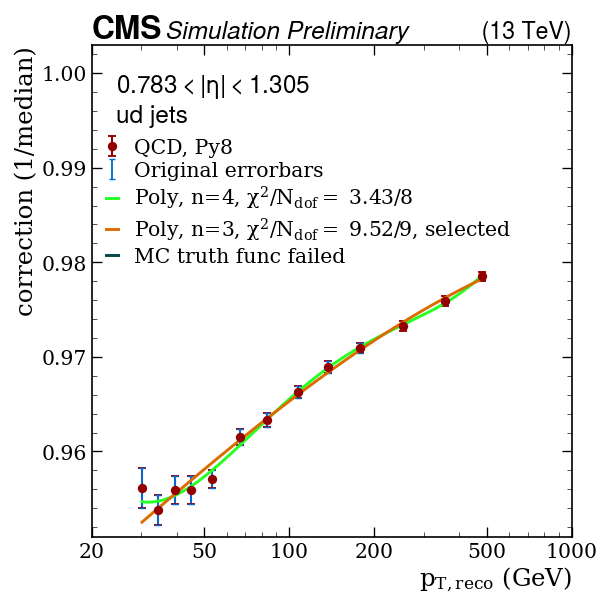

Fitting subsample:  ud Eta idx = 2, eta bin = [1.305; 1.653 ]
Winter 14 fit failed
Extended Winter 14 fit failed
Using the polinomial n=4 fit results 


/tmp/anpotreb/ipykernel_21864/164847569.py:11: RuntimeWarning: overflow encountered in exp
  + (p6*np.exp(-p7*((np.log10(x)-p8)*(np.log10(x)-p8))))


Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_ud_eta1p305to1p653.pdf / .png


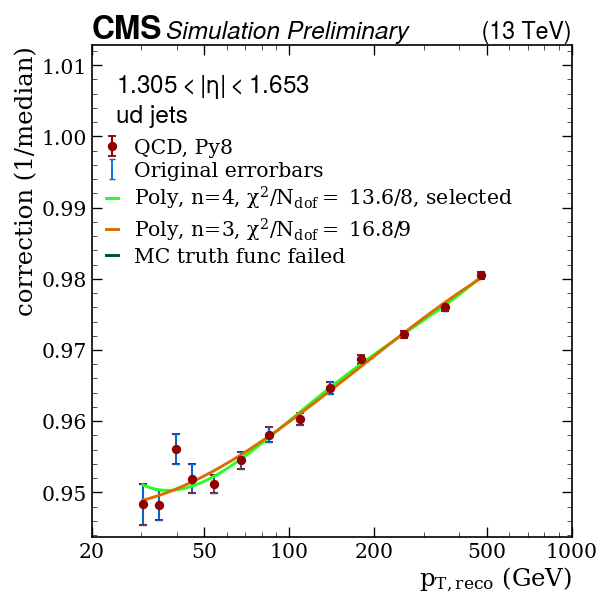

Fitting subsample:  ud Eta idx = 3, eta bin = [1.653; 1.93 ]
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 
Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_ud_eta1p653to1p93.pdf / .png


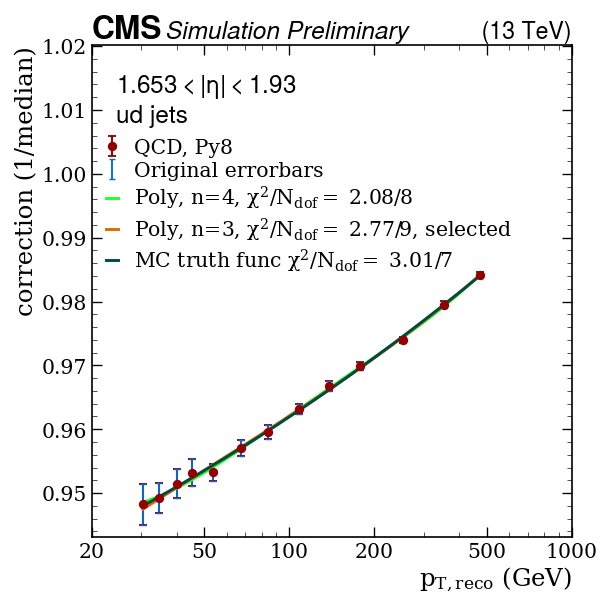

Fitting subsample:  ud Eta idx = 4, eta bin = [1.93; 2.322 ]
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 
Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_ud_eta1p93to2p322.pdf / .png


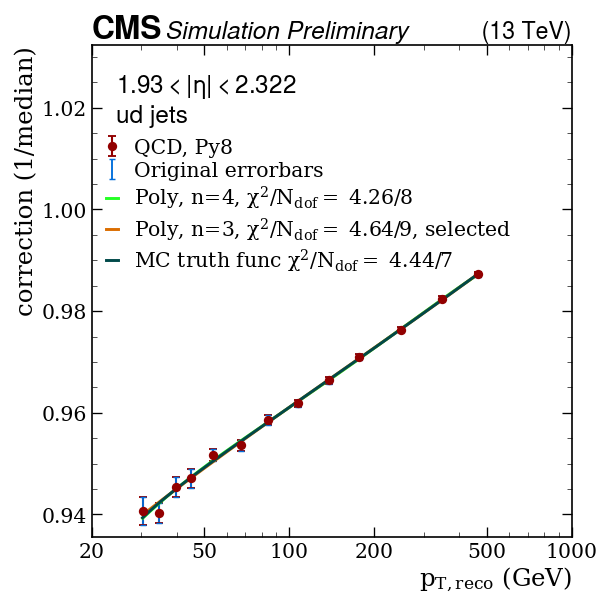

Fitting subsample:  ud Eta idx = 5, eta bin = [2.322; 2.5 ]
Winter 14 fit failed
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 


/tmp/anpotreb/ipykernel_21864/164847569.py:11: RuntimeWarning: overflow encountered in exp
  + (p6*np.exp(-p7*((np.log10(x)-p8)*(np.log10(x)-p8))))


Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_ud_eta2p322to2p5.pdf / .png


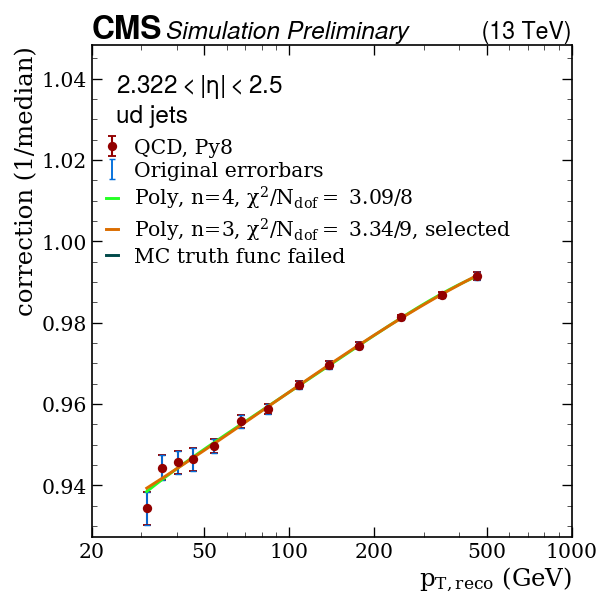

Fitting subsample:  ud Eta idx = 6, eta bin = [2.5; 2.853 ]
Winter 14 fit failed
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 
Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_ud_eta2p5to2p853.pdf / .png


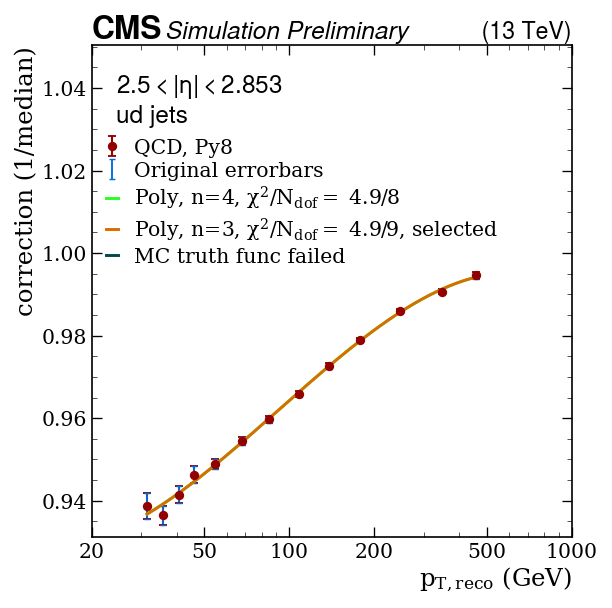

Fitting subsample:  ud Eta idx = 7, eta bin = [2.853; 3.139 ]
Winter 14 fit failed
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 
Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_ud_eta2p853to3p139.pdf / .png


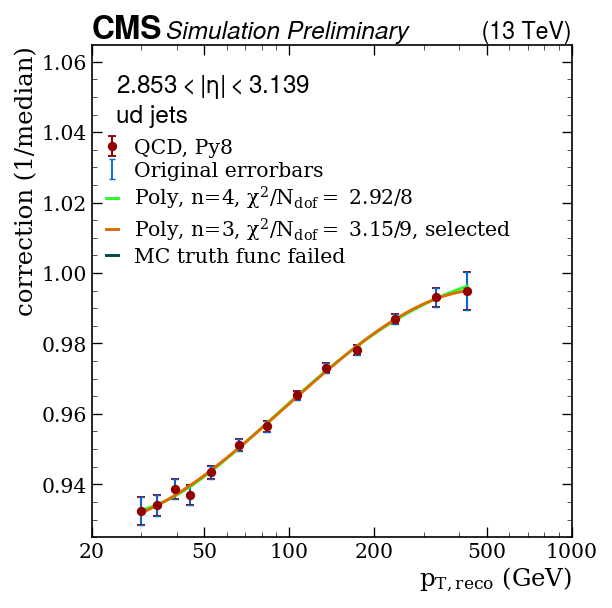

Fitting subsample:  ud Eta idx = 8, eta bin = [3.139; 3.489 ]
Winter 14 fit failed
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 
Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_ud_eta3p139to3p489.pdf / .png


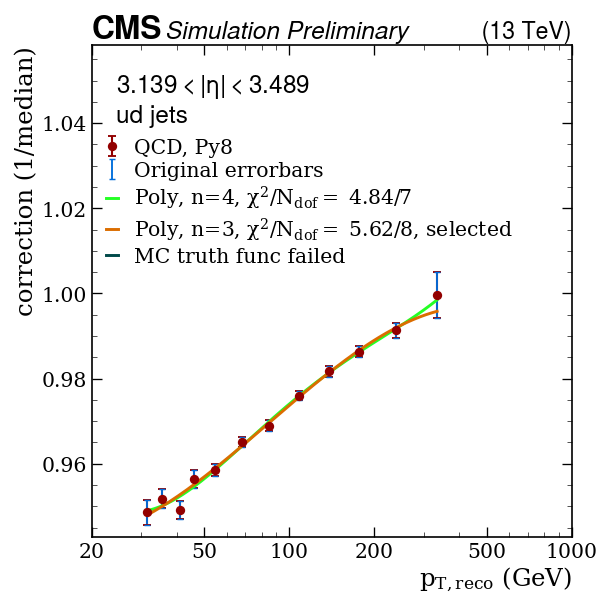

Fitting subsample:  ud Eta idx = 9, eta bin = [3.489; 5.191 ]
Winter 14 fit failed
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 
Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_ud_eta3p489to5p191.pdf / .png


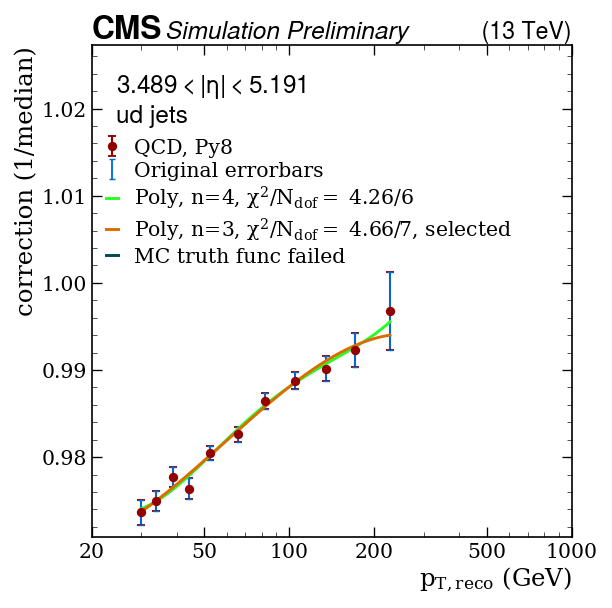

Fitting subsample:  q Eta idx = 0, eta bin = [0.0; 0.783 ]
Winter 14 fit failed
Using the polinomial n=3 fit results 


/tmp/anpotreb/ipykernel_21864/164847569.py:11: RuntimeWarning: overflow encountered in exp
  + (p6*np.exp(-p7*((np.log10(x)-p8)*(np.log10(x)-p8))))


Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_q_eta0p0to0p783.pdf / .png


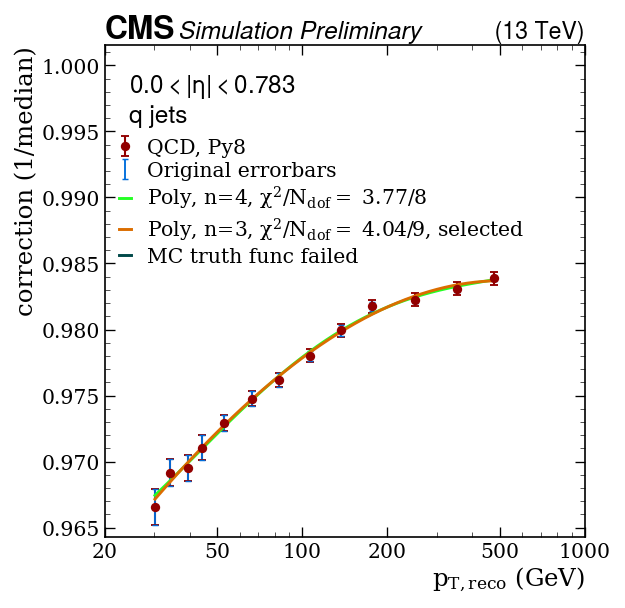

Fitting subsample:  q Eta idx = 1, eta bin = [0.783; 1.305 ]
Winter 14 fit failed
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 
Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_q_eta0p783to1p305.pdf / .png


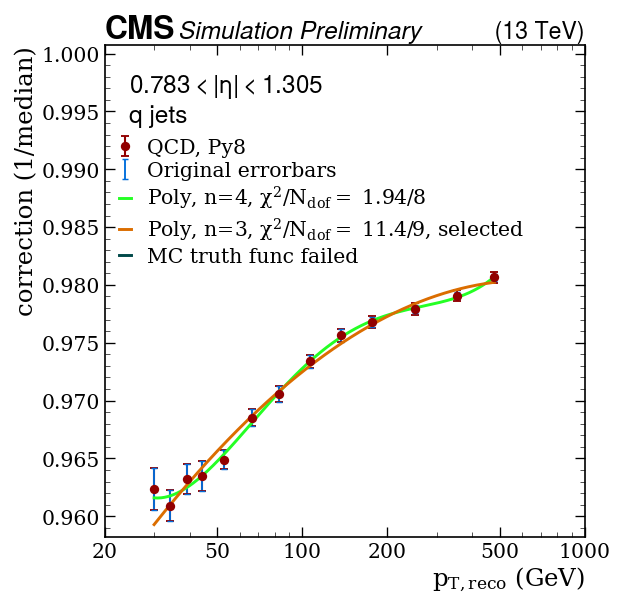

Fitting subsample:  q Eta idx = 2, eta bin = [1.305; 1.653 ]
Using the polinomial n=3 fit results 


/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_q_eta1p305to1p653.pdf / .png


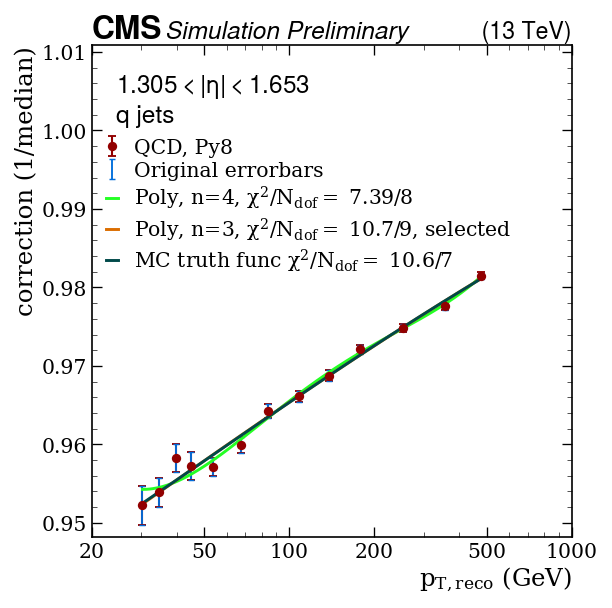

Fitting subsample:  q Eta idx = 3, eta bin = [1.653; 1.93 ]
Winter 14 fit failed
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 
Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_q_eta1p653to1p93.pdf / .png


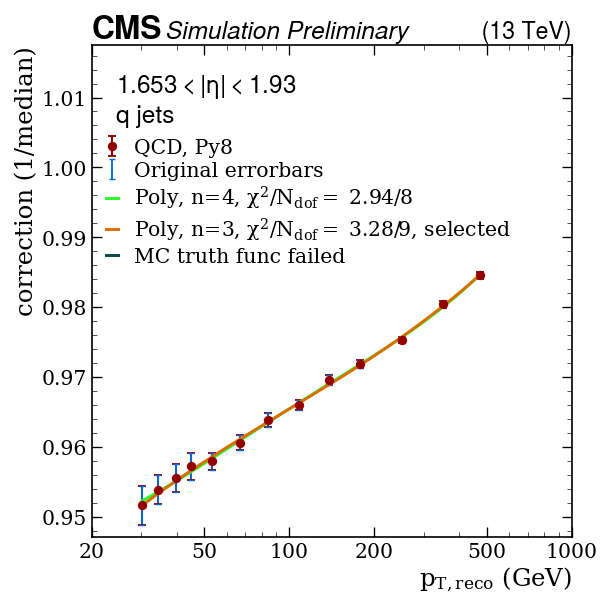

Fitting subsample:  q Eta idx = 4, eta bin = [1.93; 2.322 ]
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 


/tmp/anpotreb/ipykernel_21864/164847569.py:11: RuntimeWarning: overflow encountered in exp
  + (p6*np.exp(-p7*((np.log10(x)-p8)*(np.log10(x)-p8))))


Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_q_eta1p93to2p322.pdf / .png


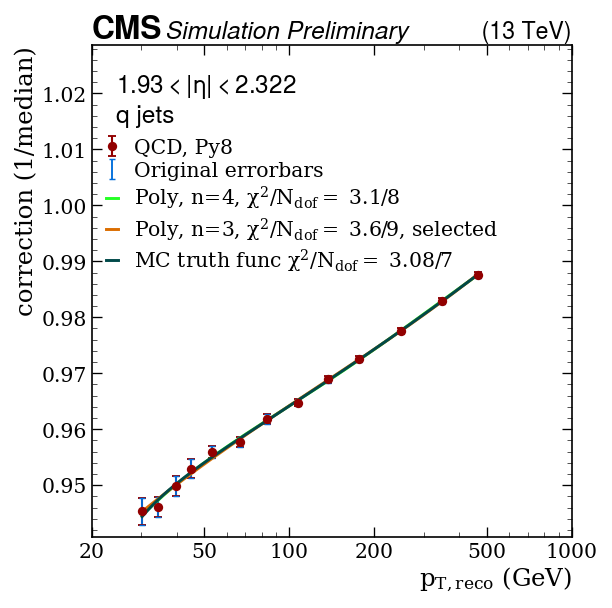

Fitting subsample:  q Eta idx = 5, eta bin = [2.322; 2.5 ]
Winter 14 fit failed
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 


/tmp/anpotreb/ipykernel_21864/164847569.py:11: RuntimeWarning: overflow encountered in exp
  + (p6*np.exp(-p7*((np.log10(x)-p8)*(np.log10(x)-p8))))


Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_q_eta2p322to2p5.pdf / .png


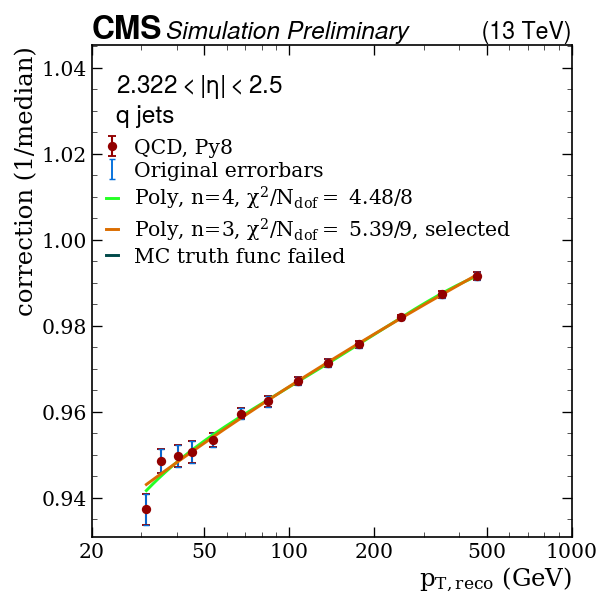

Fitting subsample:  q Eta idx = 6, eta bin = [2.5; 2.853 ]
Winter 14 fit failed
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 


/tmp/anpotreb/ipykernel_21864/164847569.py:11: RuntimeWarning: overflow encountered in exp
  + (p6*np.exp(-p7*((np.log10(x)-p8)*(np.log10(x)-p8))))


Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_q_eta2p5to2p853.pdf / .png


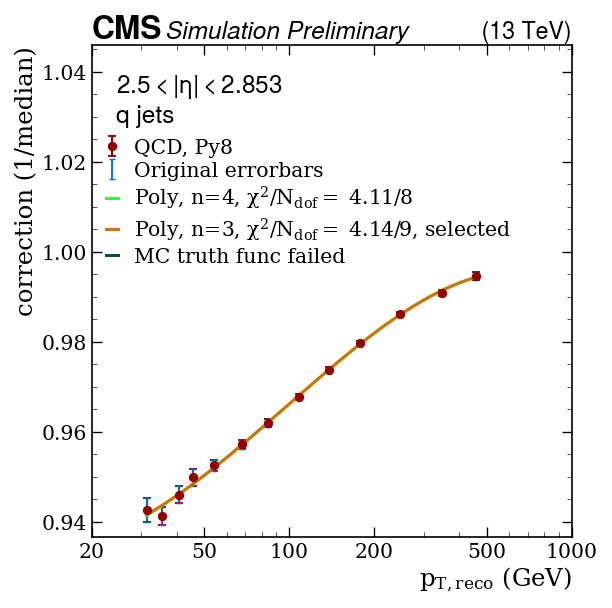

Fitting subsample:  q Eta idx = 7, eta bin = [2.853; 3.139 ]
Winter 14 fit failed
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 
Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_q_eta2p853to3p139.pdf / .png


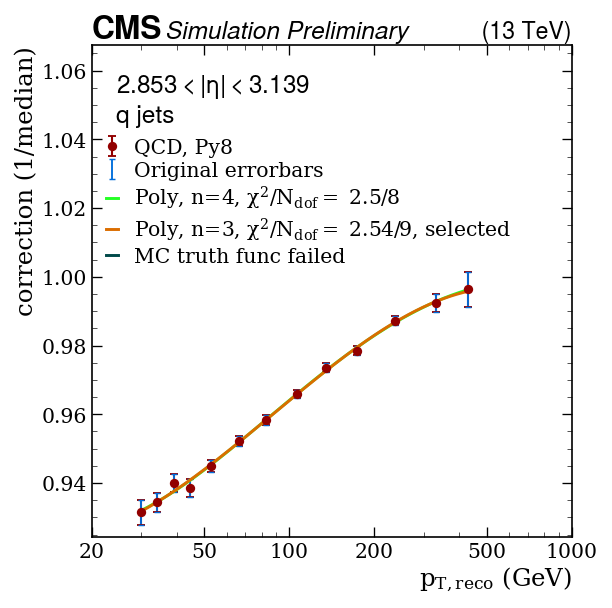

Fitting subsample:  q Eta idx = 8, eta bin = [3.139; 3.489 ]
Winter 14 fit failed
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 


/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_q_eta3p139to3p489.pdf / .png


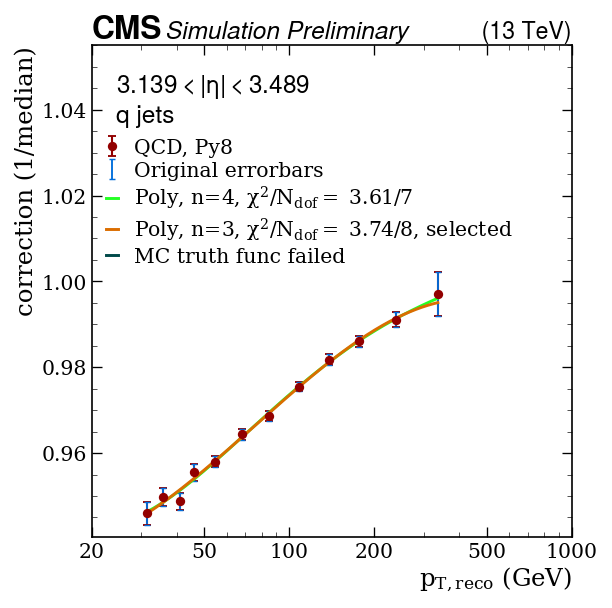

Fitting subsample:  q Eta idx = 9, eta bin = [3.489; 5.191 ]
Extended Winter 14 fit failed
Using the polinomial n=3 fit results 


/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Saving plot with the name =  fig/median_correction_fits/QCD-Py8/correction_fit_q_eta3p489to5p191.pdf / .png


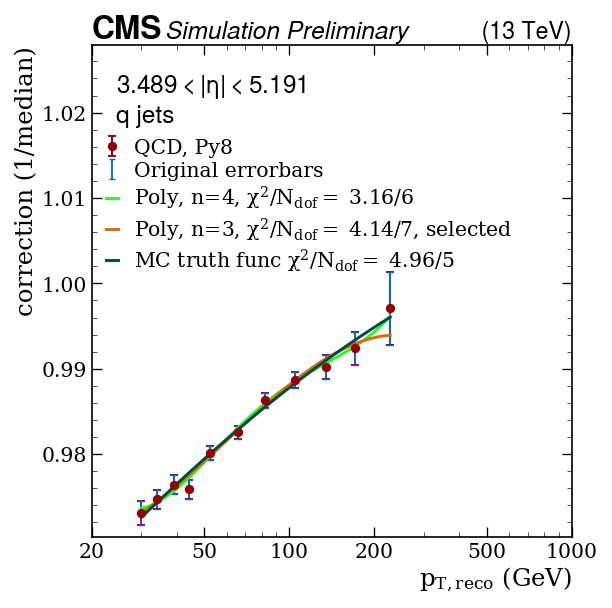

In [539]:
flavors = ['all', 'b', 'c', 'u', 'd', 'g', 's', 'ud', 'q']
# flavors = ['b', 'c', 'g', 's', 'ud', 'all', 'unmatched']
# flavors = ['b']
### Put the minimum limit on the relative uncertainty to min_rel_uncert
min_rel_uncert = 0.0005
# tags = ['_L5_QCD-MG-Py', '_L5_Pythia-TTBAR']
# tags, names = ['_L5_QCD-MG-Her', '_L5_Herwig-TTBAR'], ['QCD, MG+Her7', f"{ttbarlab} Pow+Her7"]
# tags, names = ['_L5_QCD-MG-Py', '_L5_Pythia-TTBAR'], ['QCD, MG+Py8', f"{ttbarlab} Pow+Py8"]
tags, names = ['_L5_QCD-Py'], ['QCD, Py8']
# tags = ['_L5_Pythia-TTBAR']
tags = [tag+eta_binning_str for tag in tags]

# tags = ['_L5_QCD-MG-Her_fineeta', '_L5_Herwig-TTBAR_fineeta']
# txtfile_outname = f'Summer20UL18_V2_MC/Summer20UL18_V2_MC_L5Flavor_AK4PFchs_Her{eta_binning_str}.txt'
# txtfile_outname = f'Summer20UL18_V2_MC/Summer20UL18_V2_MC_L5Flavor_AK4PFchs{eta_binning_str}.txt'
txtfile_outname = f'Summer20UL18_V2_MC/Summer20UL18_V2_MC_L5Flavor_AK4PFchs_standalonePyQCD{eta_binning_str}.txt'
# txtfile_outname = f''

# tag_full = '_L5_TTBAR-JME'
# tag_full = '_L5_QCD-MG-Her'
# tag_full = '_L5_QCD-MG-Py'

# closure = read_data("Median", "all", '_L5_QCD-MG-Py'+eta_binning_str)
closure = read_data("Median", "all", '_L5_QCD-Py'+eta_binning_str)

# df_csv = pd.read_csv('out_txt/EtaBinsvsPtBinsMedian_all_L5_QCD-JME-etaAut18'+'.csv').set_index('etaBins')
# closure = df_csv.to_numpy().transpose()
# closure = read_data("Median", 'all')

fit_res_all_tags = {}
for data_tag, data_name in np.transpose([tags, names]):

    
    for flav in flavors:
        fit_res = []
        data = read_data("Median", flav, data_tag)
        data[data==0] = np.nan
        mean = (1/data)
        mean = mean*closure # if ii==0 else mean
        meanstd = mean**2*read_data("MedianStd", flav, data_tag)
        reco_pt = read_data("MeanRecoPt", flav, data_tag)

        for etaidx in range(jeteta_bins.nbins):
            #if using Autumn18 binning, mapping to initial conditions
            meanfit = mean[:,etaidx] #*closure[:,etabin]
            meanstdfit = meanstd[:,etaidx]
            reco_ptfit = reco_pt[:,etaidx]
            
#             etabin_smalltolarge_dict = {0:0, 1:0, 1:1, 2:1, 3:1, 4:2, 5:2, 6:2, 7:2, 8:3, 9:3 }
#             # end mapping to initial conditions
#             init_vals_Winter14 = init_vals_2014[flav][etabin_smalltolarge_dict[etabin]]
            init_vals_Winter14 = [0]*6

            print('Fitting subsample: ', flav, f'Eta idx = {etaidx}, eta bin = [{jeteta_bins.edges[etaidx]}; {jeteta_bins.edges[etaidx+1]} ]', )
            fit_res_new = fit_corrections(etaidx, [meanfit, meanstdfit, reco_ptfit], flav=flav, data_tag=data_name,
                                          figdir2=figdir,
                                          jeteta_bins=jeteta_bins, pt_bins=pt_bins,
                                          init_vals_Winter14=init_vals_Winter14,
                                          plot_initial_val=False,
                                          maxlimit_static_pnt=False) # fig_name=fig_name)
            fit_res = np.concatenate([fit_res, fit_res_new])

        num = int(5 + fit_res[2])
        fit_res = np.reshape(fit_res,((len(fit_res)//num), num))
    #     etabins_samp = np.reshape(etabins_samp,((len(etabins_samp)//2), 2))
        fit_res_all[my_mapping[flav]] = fit_res
    fit_res_all_tags[data_tag] = fit_res_all

'a';

In [537]:
# txtfile_outname = f'Summer20UL18_V2_MC/Summer20UL18_V2_MC_L5Flavor_AK4PFchs_standalonePyQCD{eta_binning_str}.txt'
with open(txtfile_outname, 'w') as file:
    file.write(header_txt+'\n')
    for ii, tag in enumerate(fit_res_all_tags.keys()):
        fit_res_all = fit_res_all_tags[tag]
        for key in fit_res_all.keys():
            fit_res = fit_res_all[key]
            key = key.replace("T","J") if ii==0 else key
            file.write(f'[{key}]\n')
            file.write('{1 JetEta 1 JetPt ([0]+[1]*log10(x)+[2]*pow(log10(x),2)+[3]*pow(log10(x),3)+[4]*pow(log10(x),4)) Correction L5Flavor}\n')
            ### copy from the positive eta region into the negative
            fit_res = np.vstack([np.hstack([np.flip(fit_res[:,0:2]*-1), np.flip(fit_res[:,2:], 0)]), fit_res])
            for row in fit_res:
                row[2] = row[2]+2  #+2 because of the pt lower/higher limits that are not accounted into the # parameters before
                line2write = ('{:>11} '*5+'{:>13} '*(int(row[2])-2)).format(*row[:2], int(row[2]), *np.round(row[3:], 7))+'\n'
                file.write(line2write);

                
print("Saving the corrections with the name = ", txtfile_outname)
4; ## to suppress printouts of write

Saving the corrections with the name =  Summer20UL18_V2_MC/Summer20UL18_V2_MC_L5Flavor_AK4PFchs_standalonePyQCD_CoarseCalo.txt


### Fit median responses in a specific bin interactivelly with ip widgets

In [149]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [150]:
# interact(response_fnc_raw, x=2, p0=10);

In [151]:
# all_subsamples = ['b', 'c', 'u', 'd', 'g', 's', 'all']

# import ipywidgets as widgets

# sub = widgets.Dropdown(
#     options=all_subsamples,
#     value='b',
#     description='Subsample:',
#     disabled=False,
# )

# etabin = widgets.Dropdown(
#     options=[0,1,2,3,4],
#     value=0,
#     description='Subsample:',
#     disabled=False,
# )

# print(init_vals_2014[sub.value][etabin.value])

# p0 = widgets.FloatSlider(value=7.5, min=0, max=10.0, step=0.1,
#                          description='p0', continuous_update=True, 
#                         )
# p1 = widgets.FloatSlider(value=13.8495, min=0, max=20.0, step=0.1, description='p2', continuous_update=True,
#                         )

# p2 = widgets.FloatSlider(
#     value=17.8549,
#     min=0,
#     max=20.0,
#     step=0.1,
#     description='p2',
#     continuous_update=True,
# )

# p3 = widgets.FloatSlider(
#     value=-0.215711,
#     min=-10.0,
#     max=10.0,
#     step=0.1,
#     description='p3',
#     continuous_update=True,
# )

# p4 = widgets.FloatSlider(
#     value=0.576285,
#     min=0,
#     max=10.0,
#     step=0.1,
#     description='p4',
#     continuous_update=True,
# )

# p5 = widgets.FloatSlider(
#     value=1.42258,
#     min=0,
#     max=10.0,
#     step=0.1,
#     description='p5',
#     continuous_update=True,
# )



# display(sub, etabin, p0, p1, p2, p3, p4, p5)

# # [0.540002, 13.8495, 17.8549, -0.215711, 0.576285, 1.42258]

In [152]:
# a = widgets.IntSlider(description="Delayed", continuous_update=False)
# b = widgets.IntText(description="Delayed", continuous_update=False)
# c = widgets.IntSlider(description="Continuous", continuous_update=True)
# d = widgets.IntText(description="Continuous", continuous_update=True)

# widgets.link((a, 'value'), (b, 'value'))
# widgets.link((a, 'value'), (c, 'value'))
# widgets.link((a, 'value'), (d, 'value'))
# widgets.VBox([a,b,c,d])

In [153]:
# the_interaction = interactive(fit_corrections_for_interact, samp=all_subsamples, etabin=(0,3,1), p0=(-2,2,0.01), p1=(-200,200,0.1),
#                p2=(-10,300,0.1), p3=(-50,10,0.5), p4=(-1,10,0.1), p5=(-3,3,0.1), plot_initial_val=True ) 

# output2 = widgets.Output()

# for widg in the_interaction.children[:-1]:
# #     if "p" in widg.description:
#     widg.continuous_update = False

# samp_inter = the_interaction.children[0]
# eta_inter = the_interaction.children[1]
# pt_inter = the_interaction.children[2:8]
# # pt_inter = init_vals_2014[samp_inter.value][eta_inter.value]
# for ptii, init_val in zip(pt_inter, init_vals_2014[samp_inter.value][eta_inter.value]):
#     ptii.value = init_val
    
# def redefine_initial_vals_eta(change):
#     with output2:
# #         if change['new'] == 0:
# #             return
#         print(change['new'])
#         for ptii, init_val in zip(pt_inter, init_vals_2014[samp_inter.value][change['new']['value']]):
# #         [pt_inter[0].value, pt_inter[1].value] = init_vals_2014[samp_inter.value][change['new']['value']][:1]
#             ptii.value = init_val
            
# def redefine_initial_vals_sample(change):
#     with output2:
# #         if change['new'] == 0:
# #             return
#         print(change['new'])
#         for ptii, init_val in zip(pt_inter, init_vals_2014[change['new']['value']][eta_inter.value]):
#             ptii.value = init_val
# #         pt_inter[0].value = init_vals_2014[samp_inter.value][change['new']['value']][0]
# #     for ptii, init_val in zip(pt_inter, init_vals_2014[samp_inter.value][eta_inter.value]):
# #     ptii.value = init_val
    
# eta_inter.observe(redefine_initial_vals_eta)
    
# display(the_interaction)

In [154]:
# fig, ax = plt.subplots()
# ax.plot([1,2,3,4,5], [1,4,5,7,8], label='bla', linewidth=1.1, markersize=0);

In [155]:
print('-----'*10)
print("All done. Congrats!")

--------------------------------------------------
All done. Congrats!
